# Modelo de ABM com Microestrutura de Mercado

Este notebook apresenta um modelo de simulação baseado em agentes (ABM) que incorpora uma microestrutura de mercado por meio de um _order book_. O modelo inclui:

- **Classes de Microestrutura de Mercado:**  
  - `Ordem`: Representa uma ordem de compra ou venda.
  - `Transacao`: Representa a execução de uma transação entre um comprador e um vendedor.
  - `OrderBook`: Armazena e processa as ordens, casando-as quando possível.

- **Classes do ABM:**  
  - `BancoCentral`: Define os parâmetros macroeconômicos.
  - `Midia`: Gera notícias diárias que influenciam os agentes.
  - `Imovel`: Representa um imóvel que gera fluxo de aluguel.
  - `Agente`: Representa um investidor que toma decisões com base em seu sentimento, alocação desejada e estratégias de rebalanceamento.
  - `FII`: Representa um fundo imobiliário, cujo preço evolui com base nas transações.
  - `Mercado`: Gerencia o conjunto de agentes, o FII, o order book e o processamento diário das ordens.

Em seguida, cada parte do código será apresentada com comentários explicativos.


In [1]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import datetime as dt

import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import yfinance as yf

utils.py

DRY

In [3]:
pass

- Classe Ordem

A classe Ordem representa uma ordem de compra ou venda no mercado. Ela
contém o tipo de ordem ("compra" ou "venda"), o agente que originou a ordem,
o ativo a ser negociado, o preço limite e a quantidade.

In [4]:
@dataclass
class Ordem:
    tipo: str            # "compra" ou "venda"
    agente: "Agente"     # Agente que criou a ordem
    ativo: str           # Nome do ativo (ex.: "FII")
    preco_limite: float  # Preço máximo (para compra) ou mínimo (para venda)
    quantidade: int      # Quantidade a negociar

- Classe Transacao

 A classe Transacao representa a execução de uma transação entre um comprador
 e um vendedor. Quando uma transação é executada, os saldos dos agentes são
 ajustados, e as carteiras são atualizadas conforme a quantidade negociada e o
 preço de execução.

In [5]:
@dataclass
class Transacao:
    comprador: "Agente"
    vendedor: "Agente"
    ativo: str
    quantidade: int
    preco_execucao: float

    def executar(self) -> None:
      valor_total = self.quantidade * self.preco_execucao
      # Atualiza tanto saldo quanto caixa
      self.comprador.saldo -= valor_total
      self.comprador.caixa -= valor_total
      self.vendedor.saldo += valor_total
      self.vendedor.caixa += valor_total
      self.comprador.carteira[self.ativo] = (
          self.comprador.carteira.get(self.ativo, 0) + self.quantidade
      )
      if self.ativo in self.vendedor.carteira:
          self.vendedor.carteira[self.ativo] -= self.quantidade
          if self.vendedor.carteira[self.ativo] <= 0:
              del self.vendedor.carteira[self.ativo]


- Classe OrderBook

 A classe OrderBook representa o livro de ordens do mercado. Ela armazena
 as ordens de compra e venda (organizadas por ativo) e possui um método para
 processar e casar as ordens (executando transações quando o preço limite da
 compra for maior ou igual ao da venda).

In [6]:
class OrderBook:
    def __init__(self, params: dict = None) -> None:
        self.ordens_compra = {}
        self.ordens_venda = {}
        self.params = params if params is not None else {}

    def adicionar_ordem(self, ordem: Ordem) -> None:
        if ordem.tipo == "compra":
            self.ordens_compra.setdefault(ordem.ativo, []).append(ordem)
        elif ordem.tipo == "venda":
            self.ordens_venda.setdefault(ordem.ativo, []).append(ordem)

    def executar_ordens(self, ativo: str, mercado: "Mercado") -> None:
        if ativo in self.ordens_compra and ativo in self.ordens_venda:
            # Ordena as ordens: compras por preço limite decrescente e vendas por crescente.
            self.ordens_compra[ativo].sort(key=lambda x: x.preco_limite, reverse=True)
            self.ordens_venda[ativo].sort(key=lambda x: x.preco_limite)
            while self.ordens_compra[ativo] and self.ordens_venda[ativo]:
                ordem_compra = self.ordens_compra[ativo][0]
                ordem_venda = self.ordens_venda[ativo][0]
                if ordem_compra.preco_limite >= ordem_venda.preco_limite:
                    # Possibilidade de parametrizar o método de cálculo do preço de execução.
                    preco_execucao = (ordem_compra.preco_limite + ordem_venda.preco_limite) / 2
                    quantidade_exec = min(ordem_compra.quantidade, ordem_venda.quantidade)
                    transacao = Transacao(
                        comprador=ordem_compra.agente,
                        vendedor=ordem_venda.agente,
                        ativo=ativo,
                        quantidade=quantidade_exec,
                        preco_execucao=preco_execucao,
                    )
                    transacao.executar()
                    # Atualiza o preço do ativo no FII.
                    mercado.fii.preco_cota = preco_execucao
                    ordem_compra.quantidade -= quantidade_exec
                    ordem_venda.quantidade -= quantidade_exec
                    if ordem_compra.quantidade == 0:
                        self.ordens_compra[ativo].pop(0)
                    if ordem_venda.quantidade == 0:
                        self.ordens_venda[ativo].pop(0)
                else:
                    break

    def imprimir(self) -> None:
        print("== Order Book ==")
        print("Ordens de COMPRA:")
        for ativo, ordens in self.ordens_compra.items():
            print(f" Ativo: {ativo}")
            for ordem in ordens:
                print(f"  -> Agente {ordem.agente.id}: Preço Limite: R${ordem.preco_limite:.2f}, Quantidade: {ordem.quantidade}")
        print("Ordens de VENDA:")
        for ativo, ordens in self.ordens_venda.items():
            print(f" Ativo: {ativo}")
            for ordem in ordens:
                print(f"  -> Agente {ordem.agente.id}: Preço Limite: R${ordem.preco_limite:.2f}, Quantidade: {ordem.quantidade}")

## Classes do ABM

- **BancoCentral:** Define parâmetros macroeconômicos como taxa SELIC, expectativa de inflação e prêmio de risco.
- **Midia:** Gera um índice de notícias aleatório que influencia o sentimento dos agentes.
- **Imovel:** Representa um imóvel que gera fluxo de aluguel.
- **Agente:** Modela um investidor que possui um saldo, uma carteira de ativos, e toma decisões baseadas em seu sentimento, na alocação desejada e em expectativas. Cada agente pode criar ordens (de compra ou venda) com base em uma estratégia de rebalanceamento.
- **FII:** Representa um fundo imobiliário cujo preço (preço da cota) evolui com as transações. Ele também distribui dividendos e acumula caixa.
- **Mercado:** Gerencia o conjunto de agentes, o FII, o order book e o processamento diário das ordens. Ele atualiza o preço do FII, distribui dividendos e atualiza a volatilidade histórica dos retornos.


### **BancoCentral**




In [7]:
class BancoCentral:
    def __init__(self, params: dict = None) -> None:
        params = params if params is not None else {}
        self.taxa_selic = params.get("taxa_selic", 0.15)
        self.expectativa_inflacao = params.get("expectativa_inflacao", 0.07)
        self.premio_risco = params.get("premio_risco", 0.08)

### **Mídia**

In [8]:
class Midia:
    def __init__(self, dias, valor_inicial, sigma, valores_fixos):
        self.dias = dias
        self.valor_atual = valor_inicial
        self.sigma = sigma
        self.valores_fixos = valores_fixos
        self.t = 0  # contador de tempo
        self.historico = [valor_inicial]

    def gerar_noticia(self):
        if self.t >= self.dias + 2:
            raise StopIteration("Fim da simulação de notícias.")

        self.t += 1

        if self.t in self.valores_fixos:
            self.valor_atual = self.valores_fixos[self.t]
        else:
            passo = np.random.normal(0, self.sigma)
            self.valor_atual = np.clip(self.valor_atual + passo, -3, 3)

        self.historico.append(self.valor_atual)
        return self.valor_atual

    def get_historico(self):
        return self.historico


### **Imovel**

In [9]:
class Imovel:
    def __init__(self, valor: float, vacancia: float, custo_manutencao: float, params: dict=None) -> None:
        self.valor = valor
        self.vacancia = vacancia
        self.custo_manutencao = custo_manutencao
        # Recebe os parâmetros customizáveis ou usa os valores default
        self.params = params if params is not None else {}
        self.aluguel_factor = self.params.get("aluguel_factor", 0.005)
        self.desvio_normal = self.params.get("desvio_normal", 0.1)
        self.aluguel = self.valor * self.aluguel_factor

    def gerar_fluxo_aluguel(self) -> float:
        return self.aluguel * (1 - self.vacancia * (1 + np.random.normal(0, self.desvio_normal)))

### **FII**

In [10]:
class FII:
    def __init__(self, num_cotas: int, caixa: float, params: list = None) -> None:
        self.num_cotas = num_cotas
        self.caixa = caixa
        self.imoveis = []
        self.retornos_diarios = []
        self.preco_cota = 0
        self.historico_precos = []
        self.historico_dividendos = [self.valor_patrimonial_por_acao()]
        # Guarda os parâmetros passados ou usa um dicionário vazio se não forem fornecidos
        self.params = params if params is not None else {}

    def valor_patrimonial_por_acao(self) -> None:
        return (self.caixa + sum(imovel.valor for imovel in self.imoveis)) / self.num_cotas

    def adicionar_imovel(self, imovel: Imovel) -> None:
        self.imoveis.append(imovel)

    def calcular_fluxo_aluguel(self) -> float:
        return sum(imovel.gerar_fluxo_aluguel() for imovel in self.imoveis)

    def distribuir_dividendos(self) -> float:
        fluxo_aluguel = self.calcular_fluxo_aluguel()
        # Usa os parâmetros configuráveis para distribuição dos dividendos
        dividendos_rate = self.params.get("dividendos_taxa", 0.95)
        caixa_rate = self.params.get("dividendos_caixa_taxa", 0.05)
        dividendos = fluxo_aluguel * dividendos_rate / self.num_cotas if self.num_cotas > 0 else 0
        self.historico_dividendos.append(dividendos)
        self.caixa += fluxo_aluguel * caixa_rate
        return dividendos

    def atualizar_caixa_para_despesas(self, despesas: float) -> None:
        self.caixa -= despesas
        if self.caixa < 0:
            self.caixa = 0

    def atualizar_imoveis_investir(self, inflacao: float) -> None:
        # Usa o parâmetro para definir a fração do caixa a investir
        investimento_fracao = self.params.get("investimento_fracao", 0.50)
        valor_investir = investimento_fracao * self.caixa
        self.caixa -= valor_investir

        for imovel in self.imoveis:
            imovel.valor *= (1 + inflacao)
            imovel.valor += (valor_investir / len(self.imoveis))
            imovel.aluguel = imovel.valor * 0.005
            print(f"Imovel atualizado: Valor: R${imovel.valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

        print(f"[FII] Imóveis atualizados; reinvestido: R${valor_investir:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

    def realizar_investimento(self, valor: float) -> None:
        if self.caixa >= valor:
            self.caixa -= valor
        else:
            raise ValueError("Caixa insuficiente para realizar o investimento.")

    def calcular_retorno_diario(self, novo_preco_cota: float) -> None:
        if self.preco_cota > 0:
            retorno = (novo_preco_cota - self.preco_cota) / self.preco_cota
            self.retornos_diarios.append(retorno)
        self.preco_cota = novo_preco_cota

    def obter_estatisticas_retornos(self) -> None or dict:
        if not self.retornos_diarios:
            return None
        media_retorno = np.mean(self.retornos_diarios)
        volatilidade = np.std(self.retornos_diarios)
        return {"media_retorno": media_retorno, "volatilidade": volatilidade}

    def inicializar_historico(self, dias: int=30) -> list:
        self.historico_precos = []
        for _ in range(dias):
            self.historico_precos.append(self.valor_patrimonial_por_acao())
        return self.historico_precos


In [11]:
random.triangular(0.2, 0.5, 1)

0.5896955834744997

### **Investidores**

In [12]:
class Agente:
    def __init__(self, id: int, literacia_financeira: float, caixa: float, cotas: int, expectativa_inflacao: float, expectativa_premio: float, historico_precos: list,
                 params: dict=None) -> None:
        self.id = id
        self.LF = literacia_financeira
        self.caixa = caixa
        self.cotas = cotas


        # Probabilidade do agente negociar baseado na sua literacia financeira (função limitada - quanto menor a LF mais negocia)
        self.prob_negociar = np.clip(
            0.2 + 0.9 * ((1 - self.LF) ** 2),
            0.05,
            1.0
        )

        # Atributos de negociação
        self.saldo = caixa
        self.carteira = {"FII": cotas}

        # Atributos decisórios
        self.sentimento = 0
        self.RD = 0
        self.percentual_alocacao = 0

        # Expectativas
        self.expectativa_inflacao = expectativa_inflacao
        self.expectativa_premio = expectativa_premio

        # Histórico e estatísticas
        self.historico_precos = historico_precos  # Histórico de preços do ativo
        self.retornos_dia = []                   # Retornos diários registrados
        self.historico_riqueza = [caixa + cotas * historico_precos[-1]]
        self.dividendos_recebidos = 0

        # Lista para registrar o sentimento diário
        self.historico_sentimentos = []

        # Lista de vizinhos (outros agentes)
        self.vizinhos = []

        # Parâmetros específicos do agente (opcional)
        self.params = params if params is not None else {}

    def definir_vizinhos(self, todos_agentes: list, num_vizinhos: int = 3) -> None:
        candidatos = [agente for agente in todos_agentes if agente.id != self.id]
        self.vizinhos = random.sample(candidatos, min(num_vizinhos, len(candidatos)))

    def calcular_preco_esperado(self, literacia_financeira: float, beta: float, dividendos: float) -> float:
        # Utiliza o parâmetro beta presente em 'parametros'
        x = literacia_financeira / (np.exp(1) ** beta)
        z = (1 - beta) * (1 - literacia_financeira)
        y = 1 - x - z

        # Preço fundamentalista: usa dividendos e expectativas do agente
        preco_fundamentalista = dividendos * 12 * (1 + self.expectativa_inflacao) / self.expectativa_premio
        retorno_fundamentalista = np.log(preco_fundamentalista) - np.log(self.historico_precos[-1])

        # Estratégia Chartista: usa janela e alfas configuráveis

        def calcular_ema_curta_e_longa(self):
            """
            Calcula EMA curta e longa com base na memória do agente (proporcional à literacia financeira).
            Retorna: ema_short, ema_long
            """
            omega = int(self.LF * 252)

            janela_curta = max(2, int(omega / 4))  # janela mínima > 1

            alpha_short = 2 / (janela_curta + 1)
            alpha_long = 2 / (omega + 1)

            serie_precos = pd.Series(self.historico_precos[-omega:])

            ema_short = serie_precos.ewm(alpha=alpha_short, adjust=False).mean().iloc[-1]
            ema_long = serie_precos.ewm(alpha=alpha_long, adjust=False).mean().iloc[-1]

            return ema_short, ema_long

        ema_short, ema_long = calcular_ema_curta_e_longa(self)
        retorno_expeculador = np.log(ema_short / ema_long)


        # Ruído no retorno: desvio padrão parametrizável
        ruido_std = self.params.get("ruido_std", 0.1)
        retorno_ruido = np.random.normal(0, ruido_std)

        retorno_expectativa = (x * retorno_fundamentalista) + (y * retorno_expeculador) + (z * retorno_ruido)
        preco_esperado = self.historico_precos[-1] * np.exp(retorno_expectativa)
        return preco_esperado

    def atualizar_caixa(self, taxa_selic: float, dividendos: float) -> None:
        taxa_selic_mes = (1 + taxa_selic) ** (1 / 12) - 1
        self.caixa += self.caixa * (taxa_selic_mes + 1)
        self.caixa += dividendos

    def calcular_I_privada(self, n: int = 5, beta: int = 0, dividendos: float = 0.0) -> float:
        # Permite parametrizar os pesos dos componentes do I_privada
        peso_retorno = self.params.get("peso_retorno", 0.8)
        peso_riqueza = self.params.get("peso_riqueza", 0.4)

        preco_esperado = self.calcular_preco_esperado(self.LF, beta, dividendos)
        print(f"\tPreco esperado: {preco_esperado:.2f}")
        preco_atual = self.historico_precos[-1]

        componente_retorno = np.log(preco_esperado / preco_atual)



        if len(self.historico_riqueza) >= n:
            variacao_riqueza = (self.historico_riqueza[-1] - self.historico_riqueza[-n]) / self.historico_riqueza[-n]
            componente_riqueza = variacao_riqueza
        else:
            componente_riqueza = 0.0

        I_privada = peso_retorno * componente_retorno + peso_riqueza * componente_riqueza + np.random.normal(0, 0.05)
        return I_privada

    def calcular_I_social(self, vizinhos: list) -> float:
        sentimentos_vizinhos = []
        for vizinho in vizinhos:
            hist = vizinho.historico_sentimentos
            if not hist:
                val = 0.0
            elif len(hist) >= 3:
                val = np.mean(hist[-3:])
            else:
                val = np.mean(hist)
            if np.isnan(val):
                val = 0.0
            sentimentos_vizinhos.append(val)
        if not sentimentos_vizinhos:
            return 0.0
        I_social = np.mean(sentimentos_vizinhos)
        if np.isnan(I_social):
            I_social = 0.0
        return I_social

    def calcular_sentimento_risco_alocacao(self, mercado: "Mercado", vizinhos: list, parametros: dict) -> None:
        I_privado = self.calcular_I_privada(n=5, beta = parametros["beta"], dividendos = mercado.fii.historico_dividendos[-1])
        I_social = self.calcular_I_social(vizinhos)
        print(f"\nAgente {self.id}:")
        print(f"\tI_privado: {I_privado:.2f}")
        print(f"\tVizinhos: {[v.id for v in vizinhos]}")
        print(f"\tSentimentos dos vizinhos: {[v.sentimento for v in vizinhos]}")
        print(f"\tI_social: {I_social:.2f}")

        volatilidade_percebida = mercado.volatilidade_historica
        a_i = parametros["a0"]* self.LF #+ parametros["alpha"] * self.LF
        b_i = parametros["b0"]* (1-self.LF) #- parametros["gamma"] * self.LF
        c_i = parametros["c0"]* (1-self.LF) #- parametros["delta"] * self.LF

        S_bruto = round(a_i * I_privado + b_i * I_social + c_i * mercado.news, 4)
        self.sentimento = max(min(S_bruto, 1), -1)
        self.historico_sentimentos.append(self.sentimento)

        self.RD = (self.sentimento + 1) / 2 * volatilidade_percebida
        self.percentual_alocacao = self.RD / volatilidade_percebida if volatilidade_percebida > 0 else 0

        print(f"\tSentimento final: {self.sentimento:.2f}")
        print(f"\tRisco percebido (RD): {self.RD:.2f}")
        print(f"\tPercentual de alocação: {self.percentual_alocacao:.2f}%")

    def calcular_expectativa_inflacao(self, mercado: "Mercado", noticias: float) -> None:
        impacto_news = noticias / 100
        self.expectativa_inflacao = mercado.expectativa_inflacao * (1 - self.sentimento * 0.8) #- impacto_news

    def calcular_expectativa_premio(self, mercado: "Mercado") -> None:
        self.expectativa_premio = mercado.banco_central.premio_risco * (1 - self.sentimento * 0.2)

    def calcular_estatisticas_retoricas(self) -> None or dict:
        if len(self.historico_precos) < 2:
            return None
        retornos = [(self.historico_precos[i] - self.historico_precos[i - 1]) / self.historico_precos[i - 1]
                    for i in range(1, len(self.historico_precos))]
        media_retorno = np.mean(retornos)
        volatilidade = np.std(retornos)
        sharpe_ratio = media_retorno / volatilidade if volatilidade > 0 else 0
        return {"media_retorno": media_retorno, "volatilidade": volatilidade, "sharpe_ratio": sharpe_ratio}

    def calcular_retornos_dia(self, preco_atual: float) -> None:
        if self.historico_precos:
            preco_anterior = self.historico_precos[-1]
            retorno = (preco_atual - preco_anterior) / preco_anterior
            self.retornos_dia.append(retorno)
        self.historico_precos.append(preco_atual)

    def atualizar_historico(self, preco_fii: float) -> None:
        riqueza_atual = self.caixa + self.carteira.get("FII", 0) * preco_fii
        self.historico_riqueza.append(riqueza_atual)

    def criar_ordem(self, mercado: "Mercado", parametros: float) -> Optional[Ordem]:
        ativo = "FII"
        preco_mercado = mercado.fii.preco_cota
        if preco_mercado <= 0:
            return None

        preco_esperado = self.calcular_preco_esperado(
            literacia_financeira=self.LF,
            beta=parametros["beta"],
            dividendos=mercado.fii.calcular_fluxo_aluguel() * 0.95 / mercado.fii.num_cotas
        )
        peso_preco_esperado = parametros.get("peso_preco_esperado", 0.3)
        if preco_mercado < preco_esperado:
            qtd_min = parametros.get("quantidade_compra_min", 1)
            qtd_max = parametros.get("quantidade_compra_max", 10)
            cotas_desejadas = random.randint(qtd_min, qtd_max)
            valor_necessario = preco_mercado * cotas_desejadas
            if self.saldo >= valor_necessario:
                preco_limite = (1 - peso_preco_esperado) * preco_mercado + peso_preco_esperado * preco_esperado
                return Ordem(tipo="compra", agente=self, ativo=ativo, preco_limite=preco_limite, quantidade=cotas_desejadas)
        elif preco_mercado > preco_esperado:
            cotas_possuidas = self.carteira.get(ativo, 0)
            if cotas_possuidas > 0:
                preco_limite = (1 - peso_preco_esperado) * preco_mercado + peso_preco_esperado * preco_esperado
                divisor_venda = parametros.get("divisor_quantidade_venda", 5)
                quantidade_venda_max = int(cotas_possuidas / divisor_venda) + 1
                return Ordem(tipo="venda", agente=self, ativo=ativo, preco_limite=preco_limite,
                             quantidade=random.randint(1, quantidade_venda_max))
        return None


### **Mercado**

In [13]:
class Mercado:
    def __init__(self, agentes: Agente, imoveis: Imovel, fii: FII, banco_central: BancoCentral, midia: Midia, params: dict = None) -> None:
        self.agentes = agentes
        self.fii = fii
        self.imoveis = fii.imoveis
        self.banco_central = banco_central
        self.midia = midia
        self.params = params if params is not None else {}
        self.volatilidade_historica = self.params.get("volatilidade_inicial", 0.1)
        self.news = 0
        self.order_book = OrderBook(self.params.get("order_book", None))
        self.dia = 1  # Contador de dias

    def executar_dia(self, parametros: list) -> None:
        self.news = self.midia.gerar_noticia()
        random.shuffle(self.agentes)
        # Configuração dos dias de notícia ruim
        # bad_news_days = self.params.get("dias_noticia_ruim", [100, 101, 102, 103])
        # bad_news_value = self.params.get("valor_noticia_ruim", -3)
        # if self.dia in bad_news_days:
        #     self.news = bad_news_value
        #     print(f"\n=== Notícia Ruim no Dia {self.dia} ===")

        '''for agente in self.agentes:
            agente.parametros = self.params.get("parametros_sentimento", {})
            agente.dividendo = (
                self.fii.historico_dividendos[-1]
                if self.fii.historico_dividendos else 0.01 * self.fii.preco_cota
            )'''

        for agente in self.agentes:
            agente.calcular_sentimento_risco_alocacao(self, agente.vizinhos, parametros)
            agente.calcular_expectativa_inflacao(self.banco_central, self.news)
            agente.calcular_expectativa_premio(self)
        self.processar_ordens(parametros)
        for agente in self.agentes:
            agente.atualizar_historico(self.fii.preco_cota)

        # Distribuição de dividendos a cada 'dividendos_frequencia' dias
        dividendos_freq = self.params.get("dividendos_frequencia", 21)
        if self.dia % dividendos_freq == 0 and self.dia != 0:
            dividendos = self.fii.distribuir_dividendos()
            print(f"Dia {self.dia} - Dividendos distribuídos: {dividendos:.2f}")

        # Atualização dos imóveis a cada 'atualizacao_imoveis_frequencia' dias
        atualizacao_imoveis_freq = self.params.get("atualizacao_imoveis_frequencia", 126)
        if self.dia % atualizacao_imoveis_freq == 0 and self.dia != 0:
            inflacao_expo = self.banco_central.expectativa_inflacao ** 0.5
            self.fii.atualizar_imoveis_investir(inflacao=inflacao_expo)

        self.atualizar_volatilidade_historica()
        self.dia += 1

    def atualizar_volatilidade_historica(self) -> None:
        if len(self.fii.retornos_diarios) > 1:
            self.volatilidade_historica = np.std(self.fii.retornos_diarios) * (252 ** 0.5)

    def processar_ordens(self, parametros: list) -> None:
        for agente in self.agentes:
            if np.random.rand() < agente.prob_negociar:              #Inseri a prob do agente negociar
              ordem = agente.criar_ordem(self, parametros)
              if ordem:
                  self.order_book.adicionar_ordem(ordem)
        if self.order_book.ordens_compra.get("FII") and self.order_book.ordens_venda.get("FII"):
            self.order_book.executar_ordens("FII", self)
            self.order_book.imprimir()
        self.order_book.imprimir()
        # Reinicia o OrderBook para o próximo ciclo
        self.order_book = OrderBook(self.params.get("order_book", None))


# Função de Simulação e Plotagem

A seguir, a função `simular_mercado_e_plotar` executa a simulação por 252 dias (aproximadamente 1 ano de negociação).  
Para cada dia, o mercado executa sua rotina (atualizando notícias, processando ordens, atualizando históricos, etc.) e o preço do FII é registrado.  
Em seguida, o notebook calcula os retornos logarítmicos diários e a volatilidade rolante (usando uma janela de 20 dias), exibindo os resultados e plotando os gráficos.


In [14]:
def calcular_sentimento_medio(agentes):
    """Calcula a média dos sentimentos dos agentes em um determinado dia."""
    return np.mean([agente.sentimento for agente in agentes])


from scipy.stats import truncnorm
def gerar_literacia_financeira(media=0.4, desvio=0.2, minimo=0.2, maximo=1.0):
    """
    Gera um valor de literacia financeira com distribuição normal truncada entre 0 e 1.
    """
    a, b = (minimo - media) / desvio, (maximo - media) / desvio
    return truncnorm.rvs(a, b, loc=media, scale=desvio)



In [15]:
def simular_mercado_e_plotar():
    # Dicionário unificado de parâmetros
    sim_params = {
        # Parâmetros gerais da simulação
        "num_dias": 504,
        "total_cota": 100_000,

        # Parâmetros do FII
        "fii": {
            "num_cotas": 100_000,
            "caixa_inicial": 50_000,
            "dividendos_taxa": 0.95,          # Fração do fluxo destinada à distribuição de dividendos
            "dividendos_caixa_taxa": 0.05,      # Fração que permanece no caixa
            "investimento_fracao": 0.50,        # Fração do caixa a ser investida na atualização dos imóveis
        },

        # Parâmetros dos Imóveis (cada dicionário pode ter parâmetros específicos para o imóvel)
        "imoveis": [
            {"valor": 1_000_000, "vacancia": 0.1, "custo_manutencao": 200,
             "params": {"aluguel_factor": 0.005, "desvio_normal": 0.01}},
            {"valor": 2_000_000, "vacancia": 0.2, "custo_manutencao": 500,
             "params": {"aluguel_factor": 0.005, "desvio_normal": 0.01}},
        ],

        # Parâmetros dos Agentes
        "num_agentes": 500,
        "prop_cota_agente": 0.6,
        "agente": {
            "caixa_inicial": 10_000,
            "cotas_iniciais_primeiro": 200,
            "cotas_iniciais_outros": 200,
            "num_vizinhos": 30,
            "literacia_media": 0.3,
            "literacia_std": 0.4,
            "expectativa_inflacao": 0.05,
            "expectativa_premio": 0.08,
            # Parâmetros específicos do Agente (para cálculos internos)
            "params": {
                "window_chart": 21,
                "alpha_chart_short": 0.3,
                "alpha_chart_long": 0.1,
                "ruido_std": 0.1,
                "peso_retorno": 0.6,
                "peso_riqueza": 0.4,
            }
        },

        # Parâmetros do Banco Central
        "banco_central": {
            "taxa_selic": 0.15,
            "expectativa_inflacao": 0.07,
            "premio_risco": 0.08,
        },

        # Parâmetros da Mídia
        "midia": {
            "valor_inicial": 0,
            "sigma": 0.2,
            "valores_fixos": {10: 1, 20: 0, 30: -1, 40: 0,
                50: 2, 100: 0, 150: 0, 200: 1, 250: 1,
                300: -3, 350: 0, 400: 0, 450: 0, 500: 0,
                550: 1, 600: -3, 610: -3, 620: -2,
                700: 0, 800: 0, 850: -1, 900: 0, 950: 1,
                1000: -1, 1050: 0, 1100: 1, 1150: 1, 1200: 0, 1250: 1
            }
        },

        # Parâmetros para o sentimento (utilizados na criação de ordens e nos cálculos dos agentes)
        "parametros_sentimento": {
            "a0": 0.4,
            "b0": 0.25,
            "c0": 0.5,
            "alpha": 0.3,
            "gamma": 0.1,
            "delta": 0.01,
            "beta": 0.15,
            "peso_preco_esperado": 0.3,
            "quantidade_compra_min": 1,
            "quantidade_compra_max": 30,
            "divisor_quantidade_venda": 5,
        },

        # Parâmetros do Mercado
        "mercado": {
            "volatilidade_inicial": 0.1,
            "dividendos_frequencia": 21,            # Distribuição de dividendos a cada 21 dias
            "atualizacao_imoveis_frequencia": 126,    # Atualização dos imóveis a cada 126 dias
            #"dias_noticia_ruim": [100, 101, 102, 103],
            #"valor_noticia_ruim": -3,
        },

        # Parâmetros do OrderBook (pode ser extendido futuramente)
        "order_book": {},

        # Parâmetros para Plotagem
        "plot": {
            "window_volatilidade": 200,
        },
    }

    # --- Inicialização do FII e dos Imóveis --- -----------------------------------------------------------------------------
    total_cota = sim_params["total_cota"]
    num_agentes = sim_params["num_agentes"]
    cota_agente = int(total_cota * sim_params["prop_cota_agente"])
    cota_fii = total_cota - cota_agente

    # Criação do FII com os parâmetros do sim_params["fii"]
    fii = FII(num_cotas=sim_params["fii"]["num_cotas"],
              caixa=sim_params["fii"]["caixa_inicial"],
              params=sim_params["fii"])

    # Adiciona os imóveis ao FII
    for imovel_param in sim_params["imoveis"]:
        imovel = Imovel(valor=imovel_param["valor"],
                        vacancia=imovel_param["vacancia"],
                        custo_manutencao=imovel_param["custo_manutencao"],
                        params=imovel_param.get("params", None))
        fii.adicionar_imovel(imovel)

    # Define o preço inicial da cota e inicializa o histórico
    fii.preco_cota = fii.valor_patrimonial_por_acao()
    print(f"Preço inicial da cota: R${fii.preco_cota:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    historia = fii.inicializar_historico()

    # --- Criação dos Agentes -------------------------------------------------------------------------------------------------------
    agentes = []
    for i in range(num_agentes):
        cotas_iniciais = (sim_params["agente"]["cotas_iniciais_primeiro"]
                          if i == 0
                          else sim_params["agente"]["cotas_iniciais_outros"])
        agente = Agente(
            id=i,
            literacia_financeira=gerar_literacia_financeira(
                media=sim_params["agente"]["literacia_media"],
                desvio=sim_params["agente"]["literacia_std"]
                ),

            caixa=sim_params["agente"]["caixa_inicial"],
            cotas=cotas_iniciais,
            expectativa_inflacao=sim_params["agente"]["expectativa_inflacao"],
            expectativa_premio=sim_params["agente"]["expectativa_premio"],
            historico_precos=historia,
            params=sim_params["agente"].get("params", None)
        )
        agentes.append(agente)

    # Define os vizinhos para cada agente
    for agente in agentes:
        agente.definir_vizinhos(agentes, num_vizinhos=sim_params["agente"]["num_vizinhos"])

    # --- Criação do Banco Central, Mídia e Mercado ---------------------------------------------------------------------------------------------------------
    bc = BancoCentral(sim_params["banco_central"])

    midia = Midia(
        dias=sim_params["num_dias"],
        valor_inicial=sim_params["midia"]["valor_inicial"],
        sigma=sim_params["midia"]["sigma"],
        valores_fixos=sim_params["midia"]["valores_fixos"]
    )


    mercado = Mercado(agentes=agentes,
                      imoveis=fii.imoveis,
                      fii=fii,
                      banco_central=bc,
                      midia=midia,
                      params=sim_params["mercado"])

    # Parâmetros para o sentimento (passados para os métodos dos agentes)
    parametros_sentimento = sim_params["parametros_sentimento"]

    # --- Loop da Simulação ------------------------------------------------------------------------------------------------------------------------------------
    historico_precos_fii = []
    sentimento_medio_ao_longo_dos_dias = []
    num_dias = sim_params["num_dias"]
    for dia in range(1, num_dias + 1):
        mercado.executar_dia(parametros_sentimento)
        sentimento_medio_ao_longo_dos_dias.append(calcular_sentimento_medio(agentes))
        historico_precos_fii.append(mercado.fii.preco_cota)

    historico_precos_fii = np.array(historico_precos_fii)
    log_returns = np.diff(np.log(historico_precos_fii))

    # --- Cálculo da Volatilidade Rolante ---
    window = sim_params["plot"]["window_volatilidade"]
    volatilidade_rolante = np.full_like(log_returns, np.nan)
    for i in range(window, len(log_returns)):
        volatilidade_rolante[i] = np.std(log_returns[i-window:i]) * (252 ** 0.5)

    # --- Exibição Final---
    print(f"Preço Final da Cota: R${fii.preco_cota:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"Caixa Final do FII: R${fii.caixa:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    for agente in agentes:
      print(f"Agente {agente.id}: Caixa: R${agente.caixa:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
      + f", Sentimento: {agente.sentimento:.2f}" + f", Riqueza: R${agente.historico_riqueza[-1]:,.2f}"
      .replace(",", "X").replace(".", ",").replace("X", "."))

      #print(f"Agente {agente.id}: Caixa: R${agente.caixa:.2f}, Sentimento: {agente.sentimento:.2f}, Riqueza: R${agente.historico_riqueza[-1]:.2f}")
      ''' a riqueza do agente é calculada como a soma do seu caixa (dinheiro disponível) com o valor de mercado dos ativos que ele possui (por exemplo, o número de cotas de FII multiplicado pelo preço atual da cota).
      Portanto, se um agente investe grande parte do seu caixa em FII e o preço dessas cotas aumenta, ele pode acabar com um caixa baixo, mas uma carteira (ou patrimônio) elevada,
      já que o valor das cotas multiplicado pelo número de ativos supera o valor do caixa.'''

    # --- Plotagem dos Resultados ---
    import matplotlib.pyplot as plt
    dias_array = np.arange(num_dias)
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(dias_array, historico_precos_fii, label="Preço da Cota do FII")
    ax[0].set_title("Evolução do Preço do FII")
    ax[0].set_ylabel("Preço")
    ax[0].legend()
    ax[1].plot(dias_array[1:], volatilidade_rolante, label="Volatilidade Rolante (20 dias)", color="orange")
    ax[1].set_title("Volatilidade Rolante dos Retornos Logarítmicos")
    ax[1].set_ylabel("Volatilidade")
    ax[1].set_xlabel("Dias")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    return historico_precos_fii, log_returns, volatilidade_rolante, midia, sentimento_medio_ao_longo_dos_dias



A saída de streaming foi truncada nas últimas 5000 linhas.
	Preco esperado: 32.91

Agente 418:
	I_privado: 0.08
	Vizinhos: [52, 212, 112, 113, 89, 116, 309, 9, 166, 461, 174, 357, 19, 420, 70, 245, 455, 21, 140, 72, 267, 476, 252, 367, 54, 209, 139, 11, 237, 173]
	Sentimentos dos vizinhos: [np.float64(-0.0329), np.float64(-0.0894), np.float64(-0.0587), np.float64(-0.0778), np.float64(-0.0652), np.float64(-0.0531), np.float64(-0.0778), np.float64(0.0216), np.float64(-0.0326), np.float64(0.0087), np.float64(-0.03), np.float64(-0.0099), np.float64(-0.0119), np.float64(-0.0759), np.float64(-0.023), np.float64(-0.065), np.float64(-0.0866), np.float64(-0.0374), np.float64(-0.0602), np.float64(-0.033), np.float64(-0.0789), np.float64(0.0032), np.float64(0.0255), np.float64(-0.0069), np.float64(-0.0536), np.float64(-0.0646), np.float64(-0.0628), np.float64(-0.0717), np.float64(-0.0466), np.float64(-0.1343)]
	I_social: -0.08
	Sentimento final: -0.05
	Risco percebido (RD): 0.05
	Percentual de al

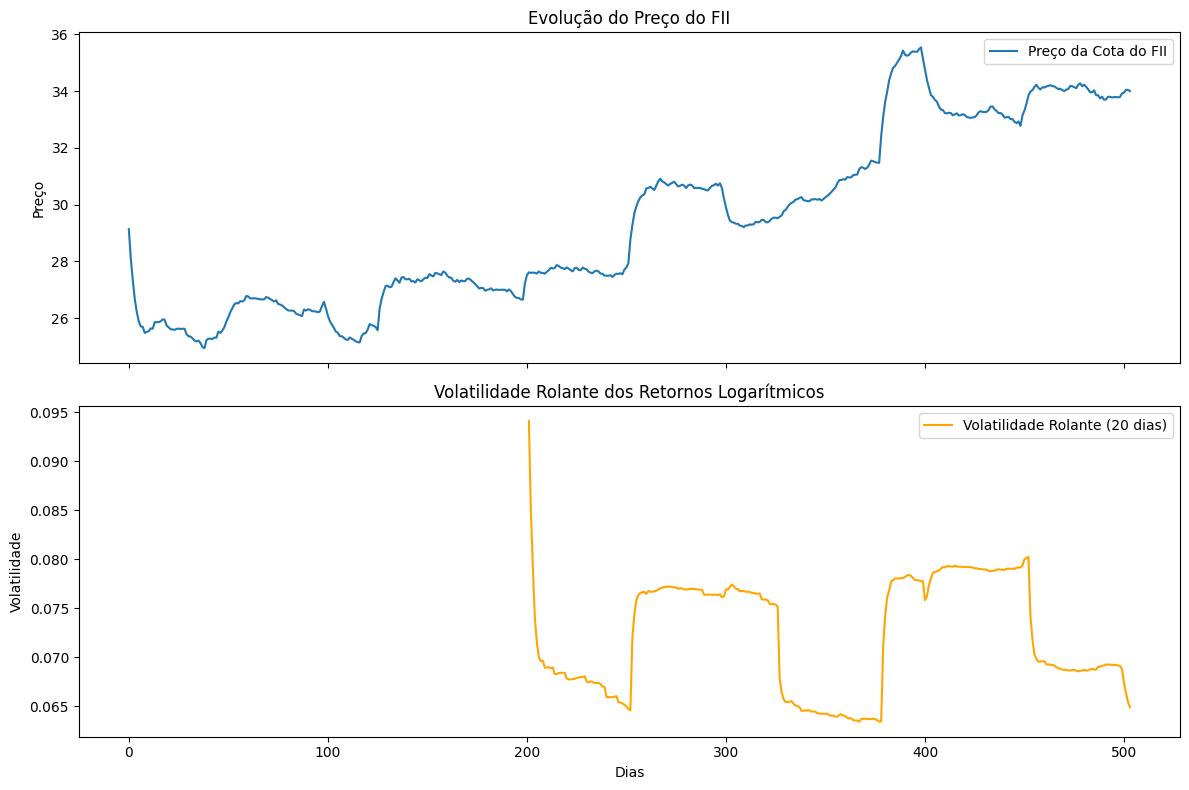

In [16]:
historico_precos_fii, log_returns, volatilidade_rolante, midia, sentimento_medio_ao_longo_dos_dias = simular_mercado_e_plotar()

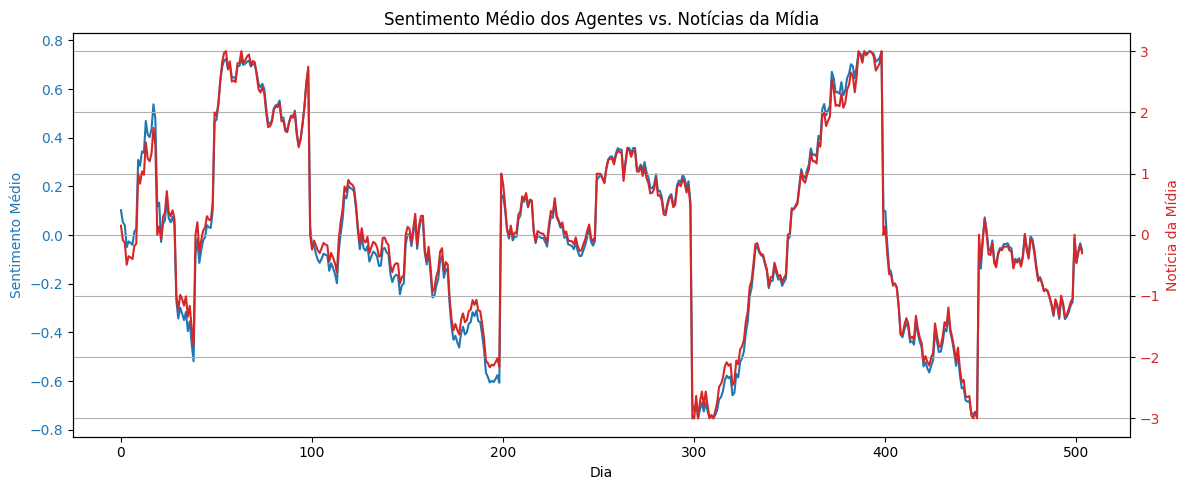

In [18]:
num_dias = 504
# Plotar ambos no mesmo gráfico com dois eixos y
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_xlabel('Dia')
ax1.set_ylabel('Sentimento Médio', color='tab:blue')
ax1.plot(range(num_dias), sentimento_medio_ao_longo_dos_dias, color='tab:blue', label='Sentimento Médio')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Notícia da Mídia', color='tab:red')
ax2.plot(range(num_dias), midia.get_historico()[1:], color='tab:red', label='Mídia')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Sentimento Médio dos Agentes vs. Notícias da Mídia")
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Experimento 02

#historico_precos_fii_2, log_returns_2, volatilidade_rolante_2, midia_2, sentimento_medio_ao_longo_dos_dias_2 = simular_mercado_e_plotar()

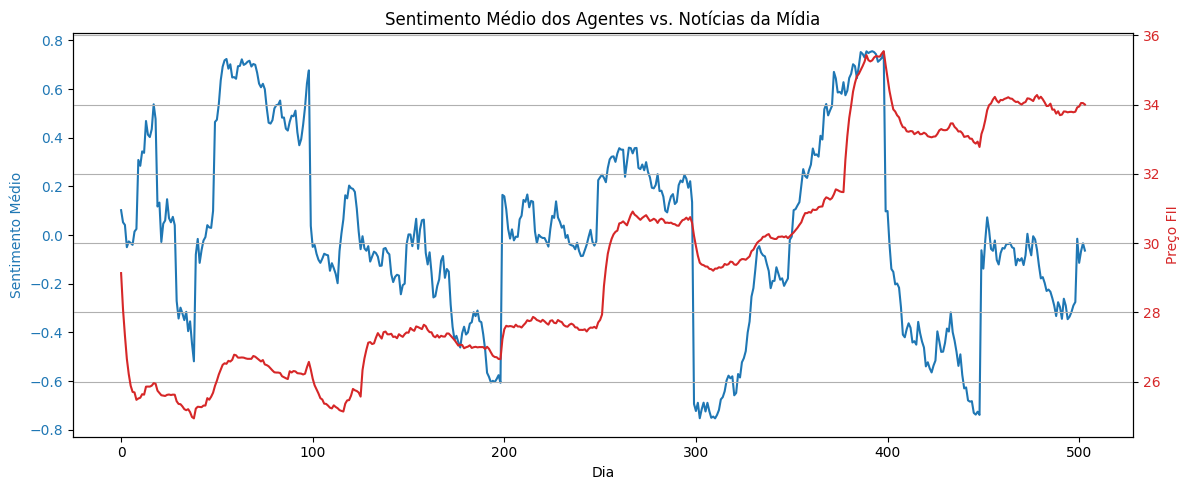

In [19]:
num_dias = 504
# Plotar ambos no mesmo gráfico com dois eixos y
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_xlabel('Dia')
ax1.set_ylabel('Sentimento Médio', color='tab:blue')
ax1.plot(range(num_dias), sentimento_medio_ao_longo_dos_dias, color='tab:blue', label='Sentimento Médio')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Preço FII', color='tab:red')
ax2.plot(range(num_dias), historico_precos_fii, color='tab:red', label='Preço FII')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Sentimento Médio dos Agentes vs. Notícias da Mídia")
fig.tight_layout()
plt.grid(True)
plt.show()

## Dados da Série Sintética

In [20]:
print(f'Skewness dos retornos diários: ', skew(log_returns, axis=0, bias=True))
print('Kurtosis dos retornos diários: ', kurtosis(log_returns, axis=0, bias=True)+3)


Skewness dos retornos diários:  0.15288926543452339
Kurtosis dos retornos diários:  18.190644796536446


In [73]:
color_line = [[ '-', '--', '-.', ':' ],
                ['black', 'blue', 'red', 'green']]



In [23]:
import yfinance as yf
fii = 'HGLG11.SA'
start = '2015-01-01'
end = '2025-02-01'

ticker = yf.Ticker(fii)
df = ticker.history(start=start, end=end)['Close']
df.index = pd.to_datetime(df.index.date, format='%Y-%m-%d')

df2 = pd.DataFrame(index=df.index[:504])
df2['preco'] = historico_precos_fii[:504]
novo_indice = pd.date_range(start='2025-03-01', periods=504, freq='B')  # 'B' = dias úteis
df2.index = novo_indice
df2

,preco
2025-03-03,29.132951
2025-03-04,28.088800
2025-03-05,27.330338
2025-03-06,26.658912
2025-03-07,26.214671
...,...
2027-01-29,33.917802
2027-02-01,33.943405
2027-02-02,34.043820
2027-02-03,34.042130


In [24]:
retorno_diario_sint = np.log(df2).diff().dropna()
retorno_semanal_sint = np.log(df2.resample('W').last()).diff().dropna()
retorno_mensal_sint = np.log(df2.resample('ME').last()).diff().dropna()

<Axes: >

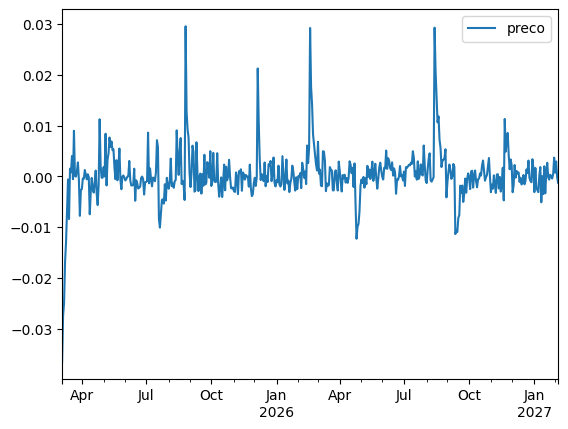

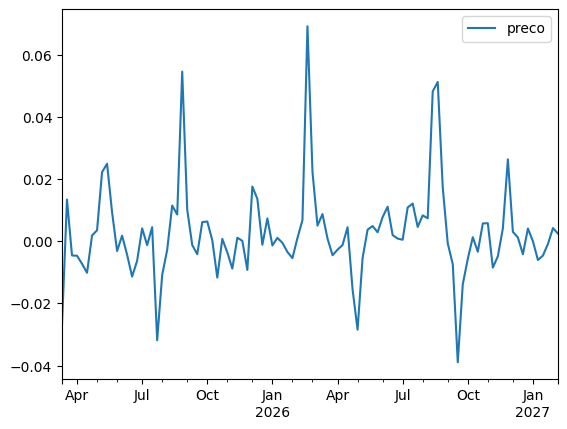

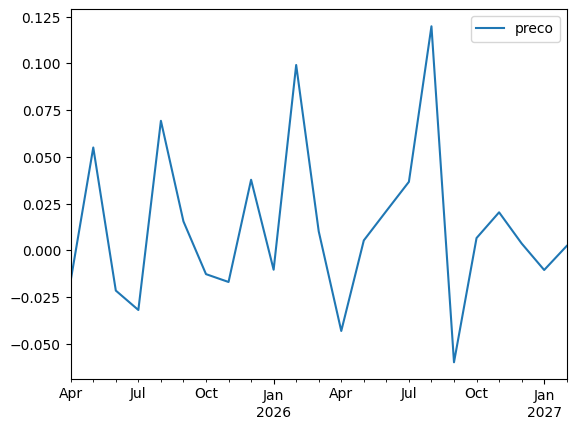

In [25]:
retorno_diario_sint.plot()
retorno_semanal_sint.plot()
retorno_mensal_sint.plot()

# **O BOOTSTRAP REFERÊNCIA**

In [26]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import datetime as dt

import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import yfinance as yf

In [27]:
# Cores extraídas visualmente (normalizadas para matplotlib)
color_coppead_vinho     = [136/255, 39/255, 61/255]   # vinho COPPEAD
color_ppgi_azul_escuro  = [0/255, 52/255, 78/255]     # azul escuro PPGI
color_ppgi_azul_claro   = [0/255, 110/255, 165/255]   # azul claro PPGI

colors = [color_ppgi_azul_escuro, color_coppead_vinho, color_ppgi_azul_claro]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))


## IFIX

### Dados

In [28]:
url = "https://docs.google.com/spreadsheets/d/1bBVbP7GH3JPcRPPn0qydQJ6H16I3yDbz/export?format=csv"

df = pd.read_csv(url, index_col="Date", parse_dates=True, dayfirst=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df["Close"] = df["Close"].astype(str).str.replace(".", "")
df["Close"] = df["Close"].astype(str).str.replace(",", ".").astype(float)
df = df.sort_index(ascending=True)
df

,Close
Date,
2015-01-02,1346.52
2015-01-05,1352.79
2015-01-06,1347.43
2015-01-07,1351.00
2015-01-08,1352.45
...,...
2025-01-30,2996.66
2025-01-31,3020.63
2025-02-03,3001.50


### Retornos

In [29]:
retorno_diario = np.log(df).diff().dropna()
retorno_semanal = np.log(df.resample('W').last()).diff().dropna()
retorno_mensal = np.log(df.resample('ME').last()).diff().dropna()

In [ ]:
color_line[1][1]

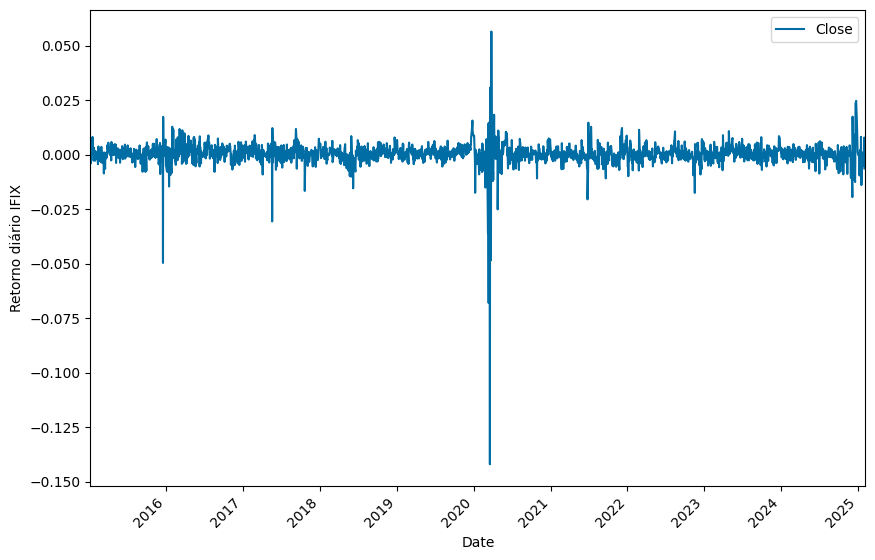

In [30]:
retorno_diario.plot(figsize=(10, 7), color=color_line[2][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([retorno_diario.index[0], retorno_diario.index[-1]]);
plt.ylabel('Retorno diário IFIX');

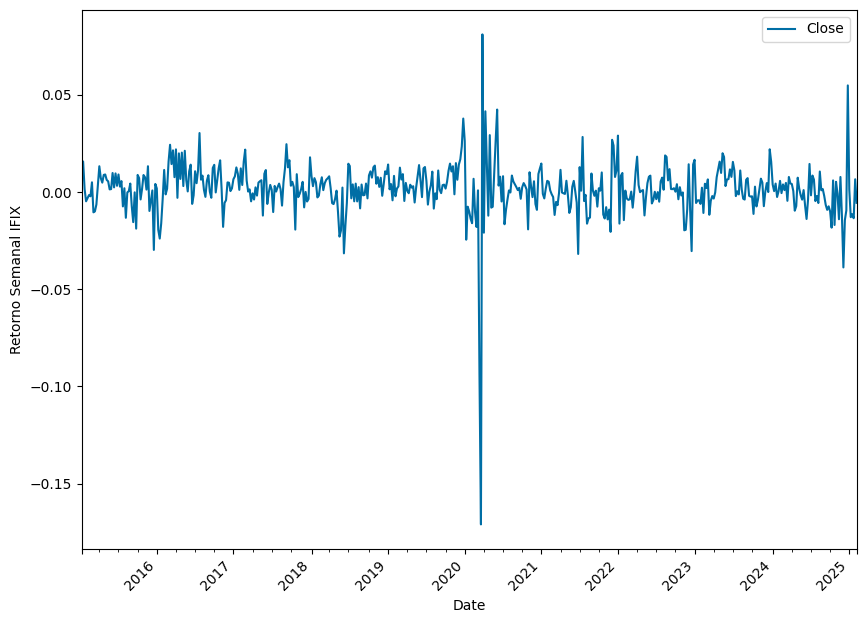

In [31]:
retorno_semanal.plot(figsize=(10, 7), color=color_line[2][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([retorno_semanal.index[0], retorno_semanal.index[-1]]);
plt.ylabel('Retorno Semanal IFIX');

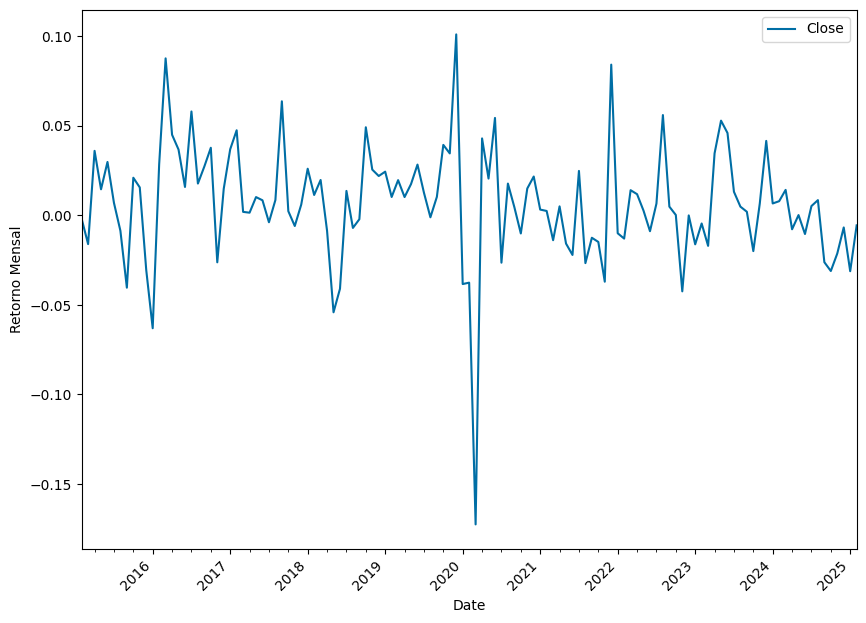

In [32]:
retorno_mensal.plot(figsize=(10, 7), color=color_line[2][1], linestyle=color_line[0][0])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([retorno_mensal.index[0], retorno_mensal.index[-1]]);
plt.ylabel('Retorno Mensal');

### Bootstrap

In [33]:
n_amostras = 1000  # número de amostras bootstrap desejadas
bootstrap_samples = []

# Gerar 100 amostras bootstrap da coluna "Retornos diários"
for i in range(n_amostras):
    # A amostra terá o mesmo tamanho da coluna "Retornos diários"
    # (que deve ter n-1 elementos, se os retornos são calculados a partir dos preços)
    sample = retorno_diario['Close'].sample(frac=1, replace=True).reset_index(drop=True)
    bootstrap_samples.append(sample)

# Valor inicial para as séries de preços (primeiro preço de fechamento)
preco_inicial = df['Close'].iloc[0]

# Para cada amostra, gerar a série de preços e inserir no DataFrame como nova coluna
for i, sample in enumerate(bootstrap_samples):
    # Cria uma série de preços com o mesmo índice do df (tamanho n)
    price_series = pd.Series(index=df.index, dtype=float)

    # Define o primeiro valor como o preço inicial
    price_series.iloc[0] = preco_inicial

    # Calcula os preços a partir do primeiro retorno da amostra bootstrap
    # A amostra tem n-1 elementos, então usamos todos para preencher price_series[1:]
    price_series.iloc[1:] = preco_inicial * np.exp(sample.reset_index(drop=True).cumsum())

    # Nome da coluna para a simulação
    col_name = f'Simulação_{i+1}'

    # Insere a nova série no DataFrame
    df[col_name] = price_series.values

In [34]:
df

,Close,Simulação_1,Simulação_2,Simulação_3,Simulação_4,Simulação_5,Simulação_6,Simulação_7,Simulação_8,Simulação_9,...,Simulação_991,Simulação_992,Simulação_993,Simulação_994,Simulação_995,Simulação_996,Simulação_997,Simulação_998,Simulação_999,Simulação_1000
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1346.52,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,...,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000,1346.520000
2015-01-05,1352.79,1347.300002,1343.435583,1338.974760,1349.446675,1351.756732,1347.154205,1347.898244,1346.578408,1346.410589,...,1350.065382,1349.872117,1346.039718,1347.523462,1349.196724,1346.735783,1347.554445,1342.525517,1336.978863,1347.011079
2015-01-06,1347.43,1338.881957,1343.589636,1338.387417,1349.755561,1352.918982,1352.342421,1348.968850,1352.937522,1347.492132,...,1350.324918,1348.562103,1351.447803,1346.313163,1346.269661,1345.466882,1348.198238,1339.992646,1342.089669,1358.798327
2015-01-07,1351.00,1336.616604,1357.673120,1347.955417,1347.087637,1360.995687,1351.824434,1346.517812,1348.135174,1348.776919,...,1342.689956,1348.348960,1345.231409,1346.610795,1357.102861,1344.525143,1350.999151,1343.061489,1344.643973,1363.839834
2015-01-08,1352.45,1331.944820,1358.880941,1350.825503,1361.684859,1357.553222,1349.855333,1343.714674,1349.494651,1342.423868,...,1344.512448,1345.999778,1341.618919,1346.272018,1361.776314,1342.618655,1350.940670,1339.844666,1347.619103,1366.185861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30,2996.66,4470.723965,2141.748158,4879.831513,3276.438566,2801.012409,3139.584863,3026.336430,3651.945450,2262.337289,...,3222.864840,2458.914710,2115.932384,3001.265586,2920.889326,2277.192595,2463.369972,2113.752452,2383.700260,2964.546854
2025-01-31,3020.63,4486.431779,2142.070718,4893.556067,3253.781345,2799.577383,3160.888896,3007.679334,3671.076846,2290.440266,...,3223.351142,2462.848604,2113.035702,2974.999076,2929.107774,2286.201934,2458.818905,2113.469595,2378.238738,2957.108525
2025-02-03,3001.50,4470.370931,2150.564249,4866.721636,3259.008810,2797.931109,3159.461410,2998.313489,3665.653072,2296.240991,...,3220.749255,2475.859440,2115.485830,2973.284145,2934.110924,2294.547970,2463.784736,2119.416223,2389.531904,2962.579303


#### Retornos Bootstrap

In [35]:
retorno_diario_boot = np.log(df).diff().dropna()
retorno_semanal_boot = np.log(df.resample('W').last()).diff().dropna()
retorno_mensal_boot = np.log(df.resample('ME').last()).diff().dropna()

In [36]:
retorno_diario_boot

,Close,Simulação_1,Simulação_2,Simulação_3,Simulação_4,Simulação_5,Simulação_6,Simulação_7,Simulação_8,Simulação_9,...,Simulação_991,Simulação_992,Simulação_993,Simulação_994,Simulação_995,Simulação_996,Simulação_997,Simulação_998,Simulação_999,Simulação_1000
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,0.004646,0.000579,-0.002293,-0.005619,0.002171,0.003882,0.000471,0.001023,0.000043,-0.000081,...,0.002630,0.002486,-0.000357,0.000745,0.001986,0.000160,0.000768,-0.002971,-0.007111,0.000365
2015-01-06,-0.003970,-0.006268,0.000115,-0.000439,0.000229,0.000859,0.003844,0.000794,0.004711,0.000803,...,0.000192,-0.000971,0.004010,-0.000899,-0.002172,-0.000943,0.000478,-0.001888,0.003815,0.008713
2015-01-07,0.002646,-0.001693,0.010427,0.007123,-0.001979,0.005952,-0.000383,-0.001819,-0.003556,0.000953,...,-0.005670,-0.000158,-0.004610,0.000221,0.008015,-0.000700,0.002075,0.002288,0.001901,0.003703
2015-01-08,0.001073,-0.003501,0.000889,0.002127,0.010778,-0.002533,-0.001458,-0.002084,0.001008,-0.004721,...,0.001356,-0.001744,-0.002689,-0.000252,0.003438,-0.001419,-0.000043,-0.002398,0.002210,0.001719
2015-01-09,0.001928,0.005406,-0.000909,0.000311,-0.003012,0.003196,0.004236,-0.002180,0.001579,-0.000789,...,0.007737,0.001069,-0.005668,-0.004069,-0.000749,0.000365,0.003726,0.000420,-0.000740,0.004374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30,0.007372,0.002828,0.001156,0.000637,-0.000943,-0.002876,-0.002596,0.002473,0.001349,-0.003387,...,-0.000620,0.000770,-0.000029,0.003962,-0.000661,0.000767,-0.001060,-0.002143,0.004262,-0.002357
2025-01-31,0.007967,0.003507,0.000151,0.002809,-0.006939,-0.000512,0.006763,-0.006184,0.005225,0.012346,...,0.000151,0.001599,-0.001370,-0.008790,0.002810,0.003949,-0.001849,-0.000134,-0.002294,-0.002512
2025-02-03,-0.006353,-0.003586,0.003957,-0.005499,0.001605,-0.000588,-0.000452,-0.003119,-0.001479,0.002529,...,-0.000808,0.005269,0.001159,-0.000577,0.001707,0.003644,0.002018,0.002810,0.004737,0.001848


## Skewness e Kurtosis

In [37]:
def plot_skew_kurtosis_distribution(df_retorno):
    """
    Calcula a skewness e a kurtosis de cada coluna do DataFrame de retornos,
    plota histogramas das distribuições de cada medida e um scatter plot
    relacionando-as.

    Parâmetros:
        df_retorno (pd.DataFrame): DataFrame onde cada coluna contém uma série de retornos.

    Retorna:
        results_df (pd.DataFrame): DataFrame com as medidas calculadas para cada simulação.
    """
    skew_list = []
    kurt_list = []
    col_names = []

    # Itera sobre as colunas para calcular as medidas
    for col in df_retorno.columns:
        col_skew = df_retorno[col].skew()
        col_kurt = df_retorno[col].kurtosis() + 3
        skew_list.append(col_skew)
        kurt_list.append(col_kurt)
        col_names.append(col)

    media_skew = np.mean(skew_list)
    media_kurt = np.mean(kurt_list)

    # Plot dos histogramas
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(skew_list, bins=50, color='blue', alpha=0.7)
    axes[0].set_title('Distribuição da Skewness')
    axes[0].set_xlabel('Skewness')
    axes[0].set_ylabel('Frequência')

    axes[1].hist(kurt_list, bins=50, color='green', alpha=0.7)
    axes[1].set_title('Distribuição da Kurtosis')
    axes[1].set_xlabel('Kurtosis')
    axes[1].set_ylabel('Frequência')

    plt.tight_layout()
    plt.show()

    # Scatter plot relacionando skewness e kurtosis
    plt.figure(figsize=(8, 6))
    plt.scatter(skew_list, kurt_list, alpha=0.7, color='purple')
    plt.xlabel('Skewness')
    plt.ylabel('Kurtosis')
    plt.title('Skewness vs Kurtosis para cada simulação')
    plt.show()

    return media_skew, media_kurt

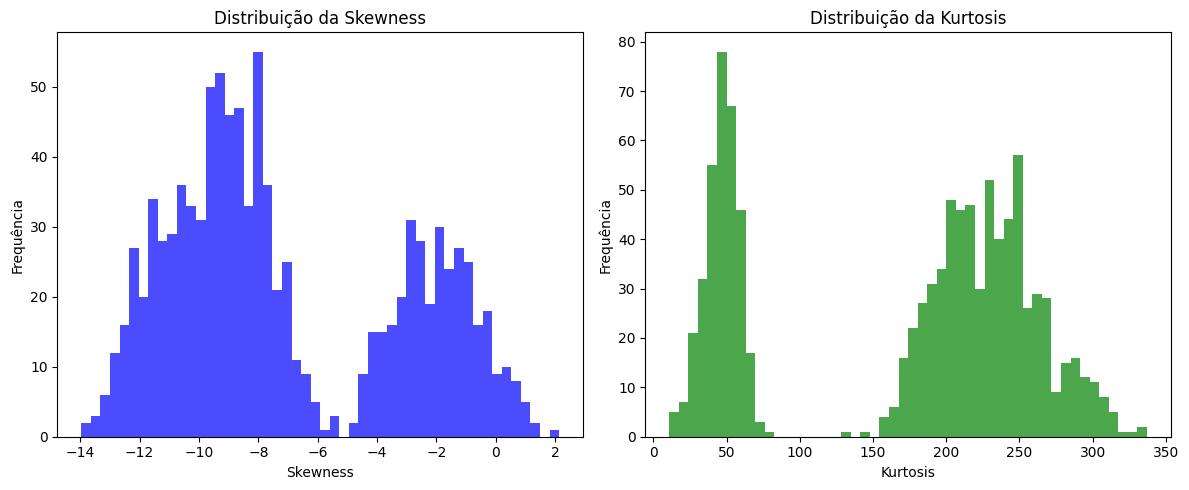

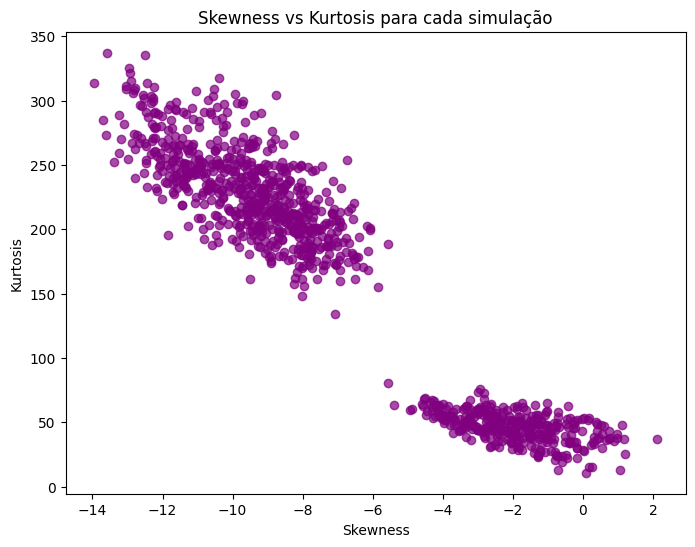

(np.float64(-7.044991896860836), np.float64(169.2532650474255))

In [38]:
plot_skew_kurtosis_distribution(retorno_diario_boot)

## Autocorrelações

In [39]:
# Criar uma tabela de autocorrelação para cada frequência
lags = 20  # Número de lags

def calcular_autocorrelacoes(df):
    autocorr_table = pd.DataFrame(index=range(0, lags+1))  # Lags de 0 a 20
    for coluna in df.columns:
        autocorr_values = sm.tsa.acf(df[coluna].dropna(), nlags=lags, fft=True)
        autocorr_table[coluna] = autocorr_values  # Inclui lag 0
    return autocorr_table

In [40]:
calcular_autocorrelacoes(retorno_diario_boot)

,Close,Simulação_1,Simulação_2,Simulação_3,Simulação_4,Simulação_5,Simulação_6,Simulação_7,Simulação_8,Simulação_9,...,Simulação_991,Simulação_992,Simulação_993,Simulação_994,Simulação_995,Simulação_996,Simulação_997,Simulação_998,Simulação_999,Simulação_1000
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.146553,-0.019084,-0.013115,-0.030771,-0.006773,0.000899,-0.003429,-0.009046,-0.018031,-0.016838,...,0.014574,-0.024061,0.014186,-0.013478,-0.012304,0.020935,-0.027028,0.001172,-0.027639,-0.019121
2,0.131602,-0.011024,-0.021727,0.001277,-0.005606,0.006856,-0.015495,0.005475,-0.007598,-0.131753,...,-0.001614,-0.010306,-0.011567,-0.016588,0.047109,-0.005465,-0.020967,-0.023668,0.008518,-0.029351
3,0.194763,-0.008255,-0.016711,-0.024910,0.030290,0.006462,0.003491,0.031413,0.008862,-0.024747,...,0.001838,0.013207,-0.008587,-0.038091,0.000878,0.014260,0.000118,0.012147,-0.019970,-0.015056
4,0.115367,0.002085,-0.009087,-0.003404,-0.008602,-0.000820,-0.016992,-0.002693,-0.023347,-0.007175,...,0.039199,0.001861,-0.013978,-0.005750,-0.004501,0.027977,0.000228,0.007644,0.012820,-0.020968
5,0.025312,0.002204,-0.006529,0.013379,-0.008562,0.017048,0.022581,0.032007,-0.032903,0.017146,...,-0.007438,0.007577,0.004548,0.029218,0.006139,0.014849,0.020985,0.005552,-0.003961,0.016487
6,-0.145398,-0.013021,-0.005381,0.011315,0.018835,0.005574,0.006995,0.024552,0.010737,0.000810,...,0.000903,0.008918,-0.035427,0.002789,-0.015410,-0.004039,0.002898,0.006612,-0.000408,-0.023417
7,0.070956,0.023451,-0.040431,-0.015683,0.012585,-0.031495,-0.013875,-0.018904,-0.010929,-0.038042,...,-0.023148,-0.007114,0.015028,0.005411,-0.016118,0.005372,-0.000444,-0.020133,-0.020547,-0.003152
8,0.019313,0.005919,-0.009565,-0.000633,-0.027171,-0.021273,-0.014413,-0.005528,-0.013975,0.034625,...,0.013436,-0.022634,-0.000545,-0.010714,-0.012277,0.044336,-0.024930,0.007658,-0.004856,0.006659
9,-0.058165,-0.006554,0.008678,-0.023154,0.002861,-0.008730,0.001684,0.003029,0.000578,0.040078,...,-0.010535,0.044069,0.029917,-0.018089,-0.001873,0.011986,-0.012750,0.004489,0.002516,-0.038015


### Distribuição das autocorrelações

In [41]:
import statsmodels.api as sm


def plot_autocorr_distribution(df, lags=20):
    """
    Calcula a tabela de autocorrelações para cada coluna do DataFrame (cada simulação)
    utilizando nlags=lags. Em seguida, para cada lag, calcula a média e o desvio padrão
    das autocorrelações entre as simulações e plota a média com um intervalo de confiança
    (média ± desvio padrão).

    Parâmetros:
        df : pd.DataFrame
            DataFrame cujas colunas contêm séries (por exemplo, retornos).
        lags : int, opcional (padrão=20)
            Número de lags a serem considerados (de 0 até lags).

    Retorna:
        autocorr_table : pd.DataFrame
            Tabela com as autocorrelações para cada coluna (simulação).
        mean_autocorr : pd.Series
            Média das autocorrelações para cada lag.
        std_autocorr : pd.Series
            Desvio padrão das autocorrelações para cada lag.
    """
    # Calcula a tabela de autocorrelações (cada linha = um lag, cada coluna = simulação)
    autocorr_table = pd.DataFrame(index=range(0, lags+1))
    for col in df.columns:
        autocorr_values = sm.tsa.acf(df[col].dropna(), nlags=lags, fft=True)
        autocorr_table[col] = autocorr_values

    # Calcula a média e o desvio padrão por lag (linha)
    mean_autocorr = autocorr_table.mean(axis=1)
    std_autocorr = autocorr_table.std(axis=1)

    # Define os limites do intervalo de confiança ilustrativo: média ± desvio padrão
    upper_bound = mean_autocorr + std_autocorr
    lower_bound = mean_autocorr - std_autocorr

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(mean_autocorr.index, mean_autocorr, marker='o', linestyle='-', label='Média')
    plt.fill_between(mean_autocorr.index, lower_bound, upper_bound,
                     color='gray', alpha=0.3, label='Média ± Desvio Padrão')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelação')
    plt.title('Distribuição de Autocorrelação para cada Lag')
    plt.legend()
    plt.show()

    return autocorr_table, mean_autocorr, std_autocorr

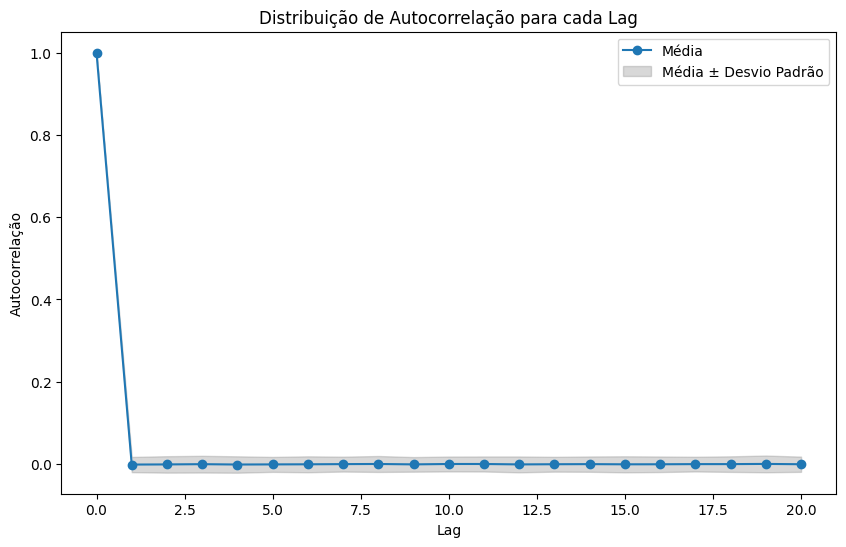

In [42]:
autocorr_table, mean_autocorr, std_autocorr = plot_autocorr_distribution(retorno_diario_boot, lags=20)

### Comparação com a série sintética

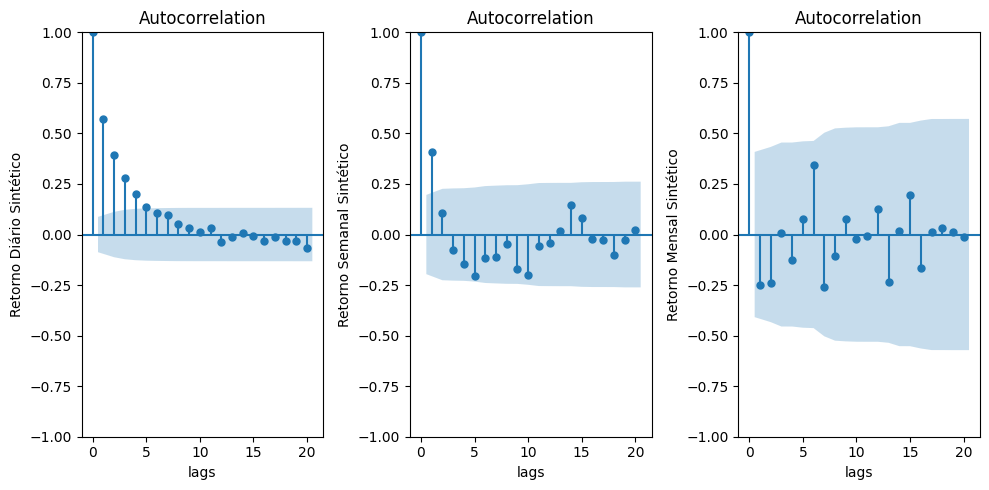

In [43]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(retorno_diario_sint, lags=20, ax=ax, alpha=0.05)
plt.xlabel('lags')
plt.ylabel('Retorno Diário Sintético')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(retorno_semanal_sint, lags=20, ax=ax, alpha=0.05)
plt.xlabel('lags')
plt.ylabel('Retorno Semanal Sintético')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(retorno_mensal_sint, lags=20, ax=ax, alpha=0.05)
plt.xlabel('lags')
plt.ylabel('Retorno Mensal Sintético')

plt.tight_layout()

In [44]:
def plot_comparison(means, stds, comp_values):
    """
    Plota um gráfico comparando os limites (média ± 2*std) com os valores da lista comp_values.

    Parâmetros:
        means (list ou array): Lista dos valores médios para cada lag.
        stds (list ou array): Lista dos desvios-padrão para cada lag.
        comp_values (list ou array): Lista de valores a serem comparados (um valor por lag).

    O gráfico exibido apresenta:
        - A linha dos limites superiores (mean + 2*std) e inferiores (mean - 2*std);
        - Uma faixa sombreada entre os limites;
        - Uma linha conectando os pontos de comp_values.
    """
    lags = np.arange(len(means))
    means = np.array(means)
    stds = np.array(stds)
    comp_values = np.array(comp_values)

    upper_bound = means + 2 * stds
    lower_bound = means - 2 * stds

    plt.figure(figsize=(10, 6))

    # Plot dos limites e da média
    plt.plot(lags, means, 'k--', label='Média')
    plt.plot(lags, upper_bound, 'b--')#, label='Média + 2*Std')
    plt.plot(lags, lower_bound, 'b--')#, label='Média - 2*Std')
    plt.fill_between(lags, lower_bound, upper_bound, color='lightblue', alpha=0.5)

    # Plot dos valores de comparação
    plt.plot(lags, comp_values, 'r-', marker='o', label='Valores comparados')

    plt.xlabel('Lag')
    plt.ylabel('Valor')
    plt.title('Comparação: Limites vs. Valores')
    plt.legend()
    plt.show()

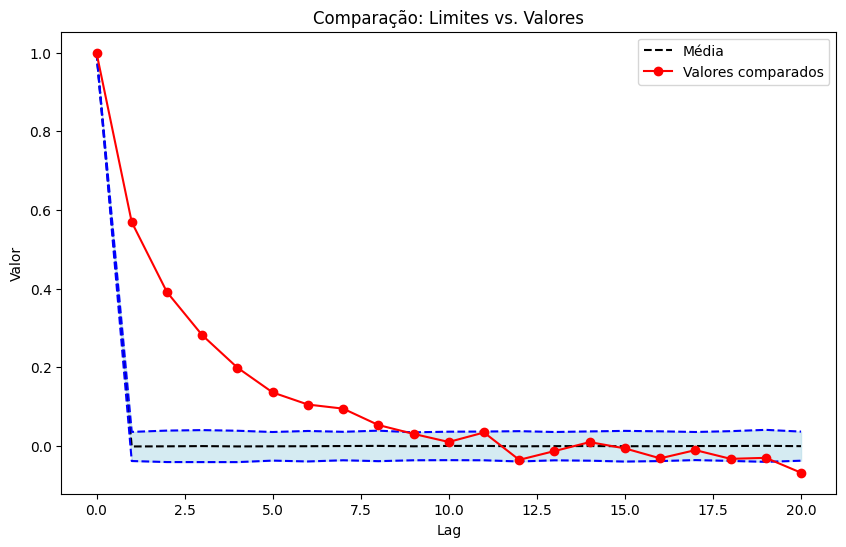

In [45]:
dados_amostra_dia = calcular_autocorrelacoes(retorno_diario_sint)
plot_comparison(mean_autocorr, std_autocorr, dados_amostra_dia )

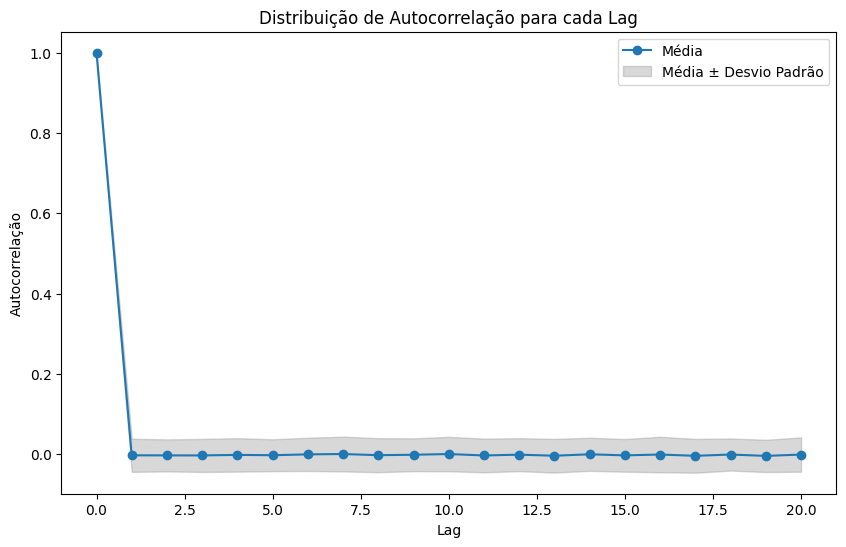

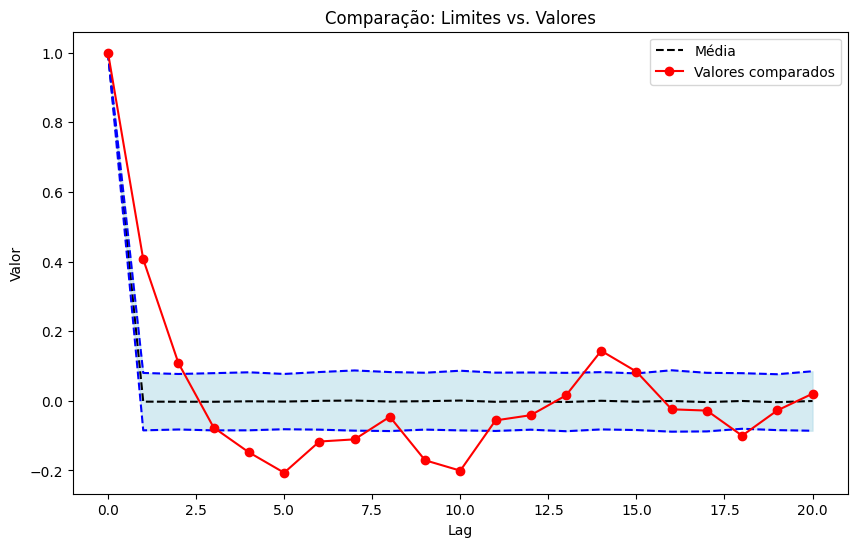

In [46]:
autocorr_table_sem, mean_autocorr_sem, std_autocorr_sem = plot_autocorr_distribution(retorno_semanal_boot, lags=20)
dados_amostra_sem = calcular_autocorrelacoes(retorno_semanal_sint)
plot_comparison(mean_autocorr_sem, std_autocorr_sem, dados_amostra_sem )


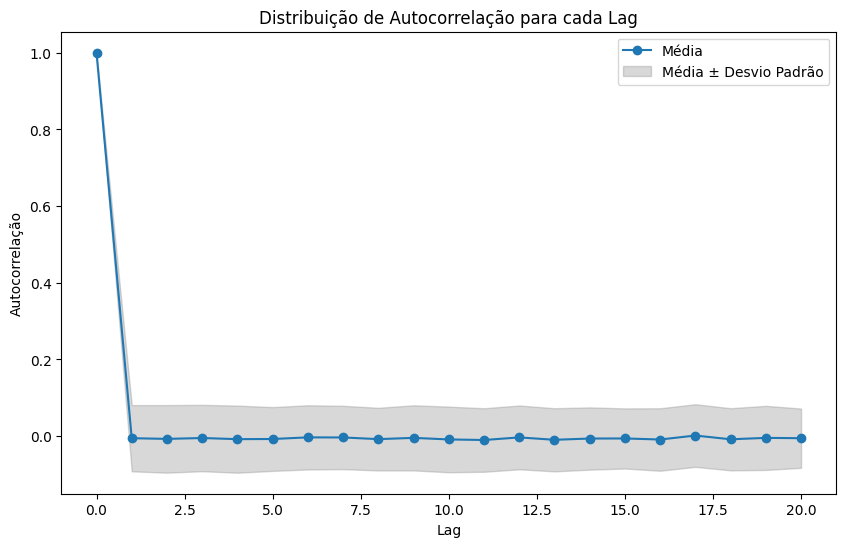

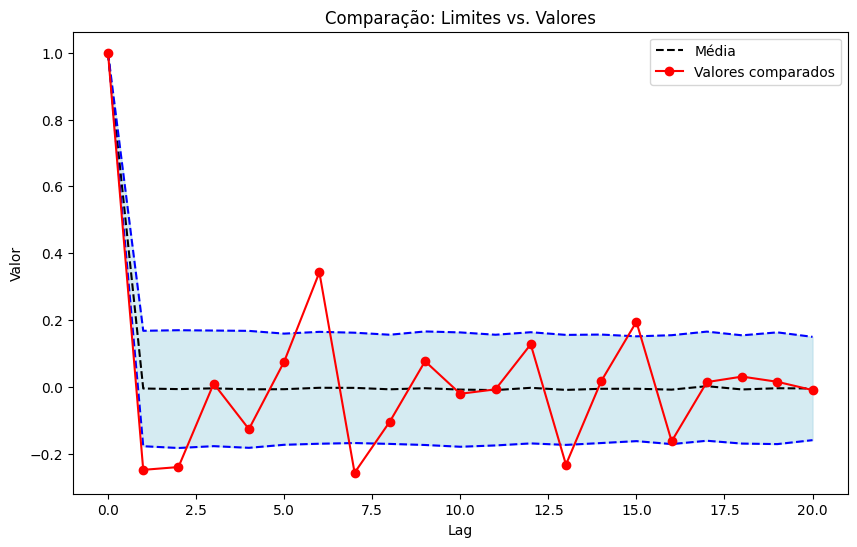

In [47]:
autocorr_table_mes, mean_autocorr_mes, std_autocorr_mes = plot_autocorr_distribution(retorno_mensal_boot, lags=20)
dados_amostra_mes = calcular_autocorrelacoes(retorno_mensal_sint)
plot_comparison(mean_autocorr_mes, std_autocorr_mes, dados_amostra_mes )

In [48]:
def plot_separate_and_combined_cdfs(bootstrap_df, comparison_series):
    # 1. Gráfico com as CDFs das amostras bootstrap
    plt.figure(figsize=(10, 6))
    for col in bootstrap_df.columns:
        # Ordena a amostra e calcula sua CDF
        sample = np.sort(bootstrap_df[col].values)
        cdf = np.arange(1, len(sample) + 1) / len(sample)
        plt.plot(sample, cdf, color='blue', alpha=0.1)
    plt.title("CDFs das Amostras Bootstrap")
    plt.xlabel("Valores")
    plt.ylabel("CDF")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Gráfico com a CDF da série de comparação
    # Garantir que a série de comparação seja um vetor 1D
    comp = np.sort(np.array(comparison_series).flatten())
    cdf_comp = np.arange(1, len(comp) + 1) / len(comp)
    plt.figure(figsize=(10, 6))
    plt.plot(comp, cdf_comp, color='purple', linewidth=2, label='Série de Comparação')
    plt.title("CDF da Série de Comparação")
    plt.xlabel("Valores")
    plt.ylabel("CDF")
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Gráfico combinado com ambas as CDFs
    plt.figure(figsize=(10, 6))
    # CDFs bootstrap
    for col in bootstrap_df.columns:
        sample = np.sort(bootstrap_df[col].values)
        cdf = np.arange(1, len(sample) + 1) / len(sample)
        plt.plot(sample, cdf, color='blue', alpha=0.1)
    # CDF da série de comparação
    plt.plot(comp, cdf_comp, color='purple', linewidth=2, label='Série de Comparação')
    plt.title("CDFs das Amostras Bootstrap e Série de Comparação")
    plt.xlabel("Valores")
    plt.ylabel("CDF")
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

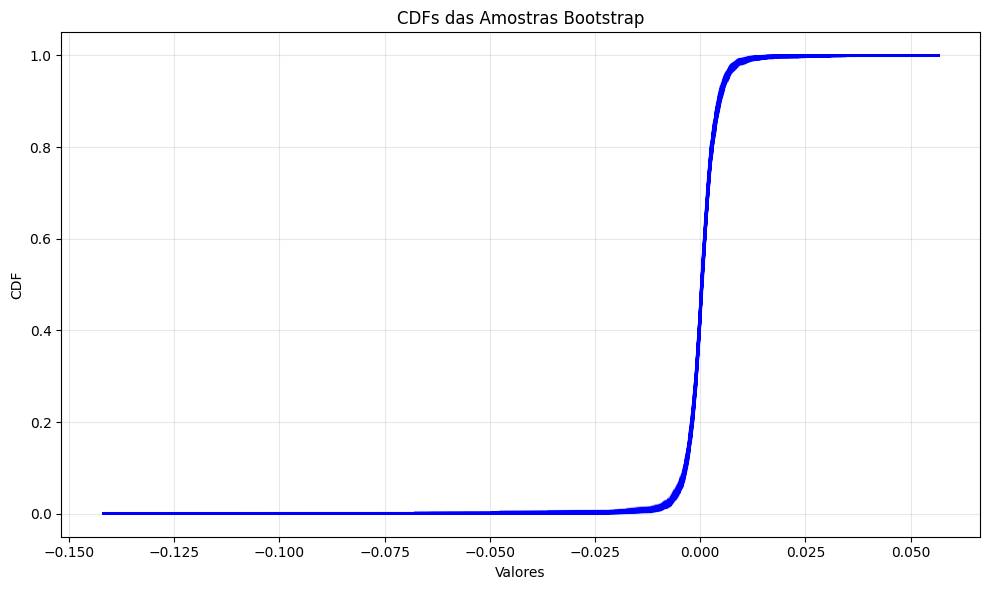

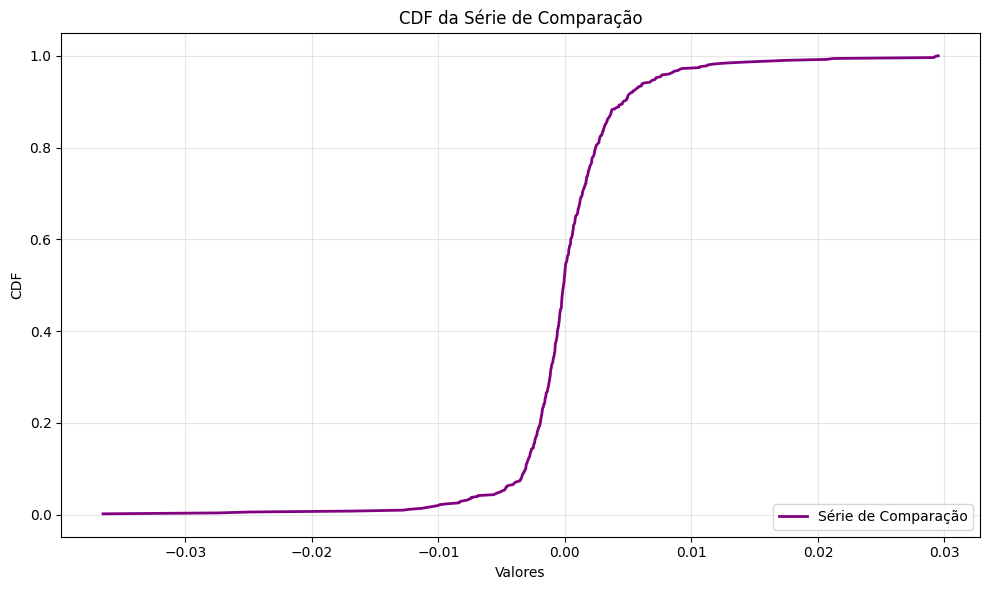

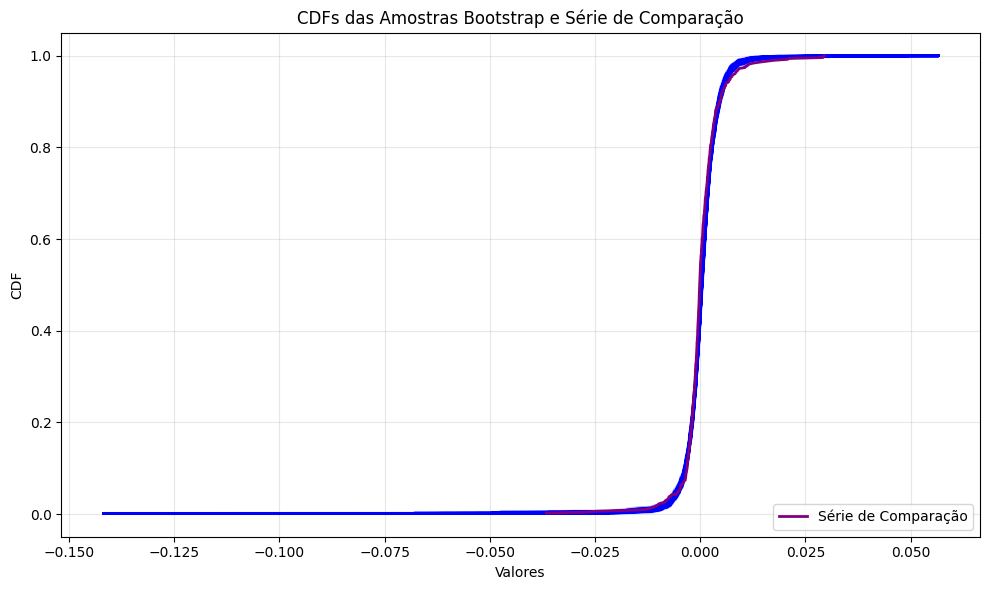

In [49]:
plot_separate_and_combined_cdfs(retorno_diario_boot, retorno_diario_sint)

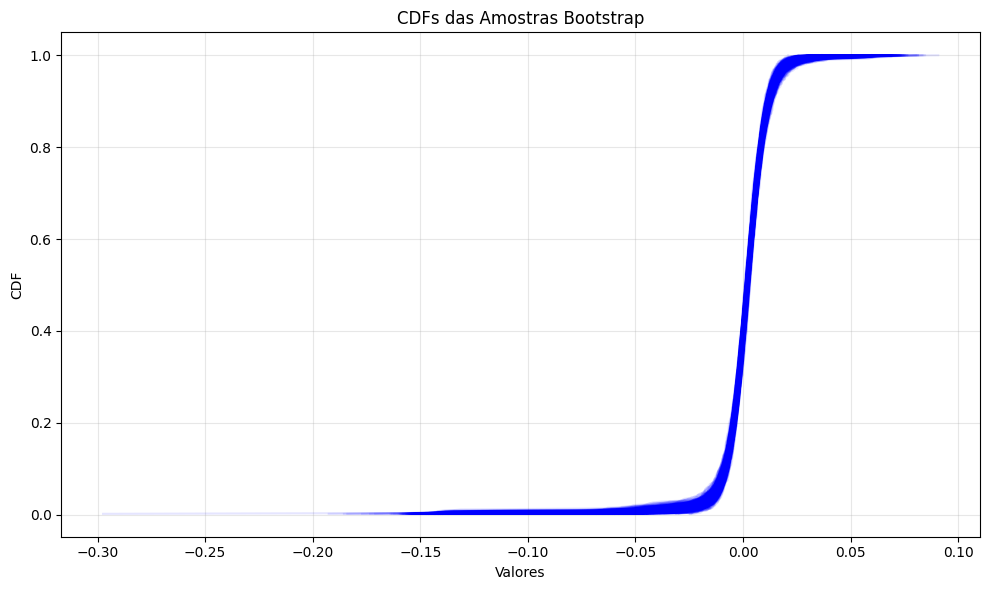

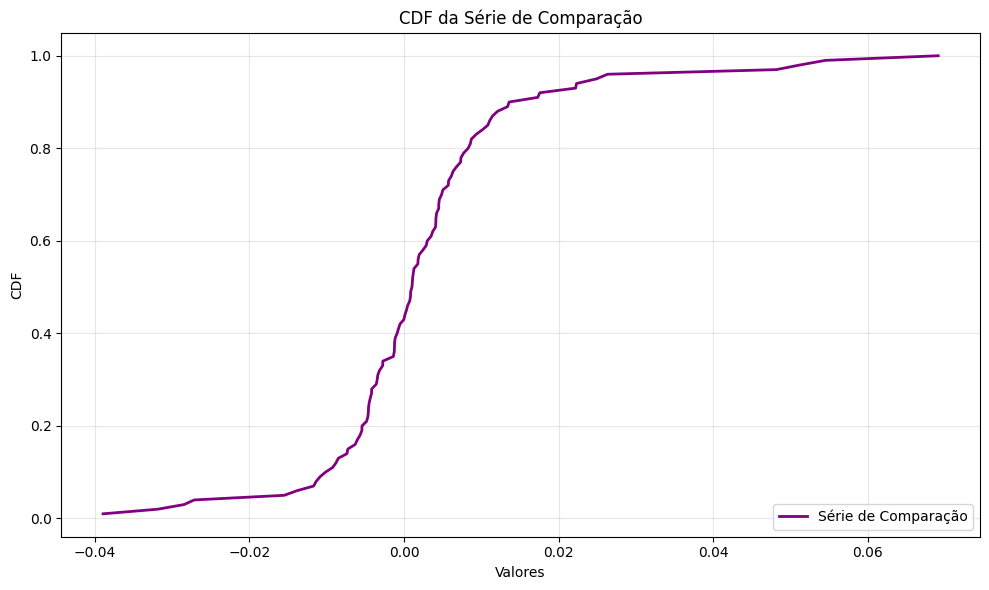

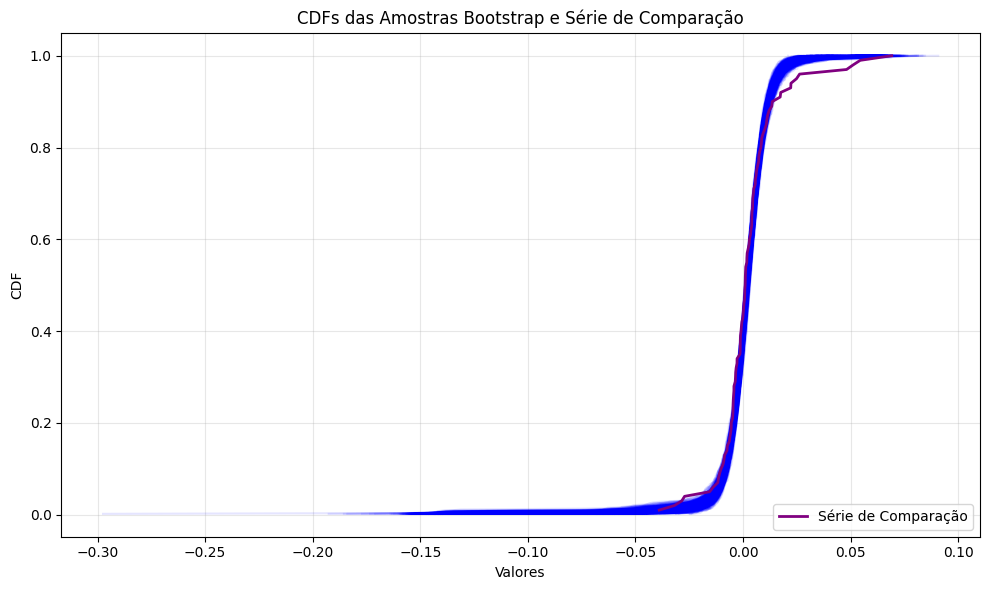

In [50]:
plot_separate_and_combined_cdfs(retorno_semanal_boot, retorno_semanal_sint)

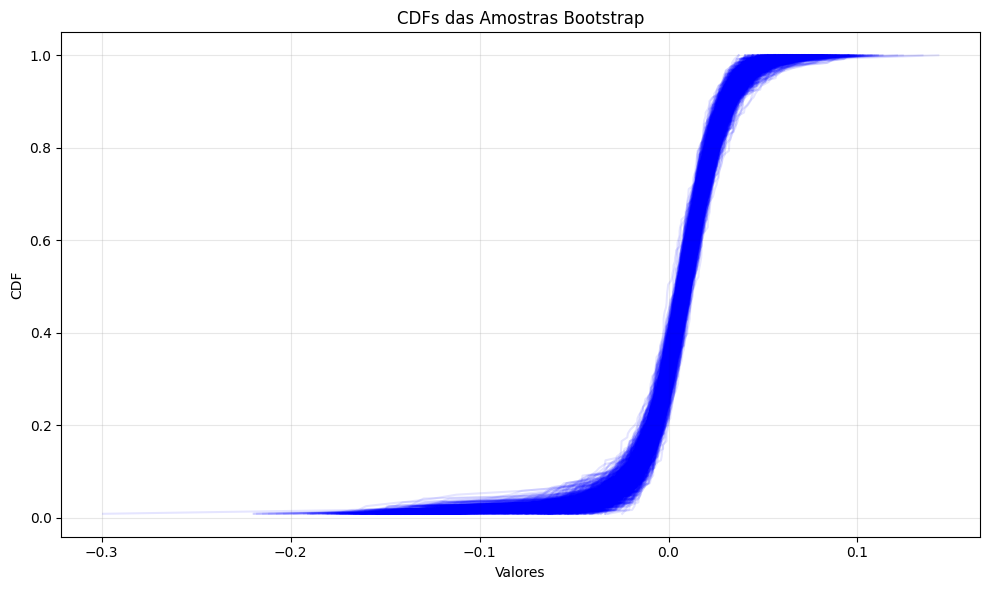

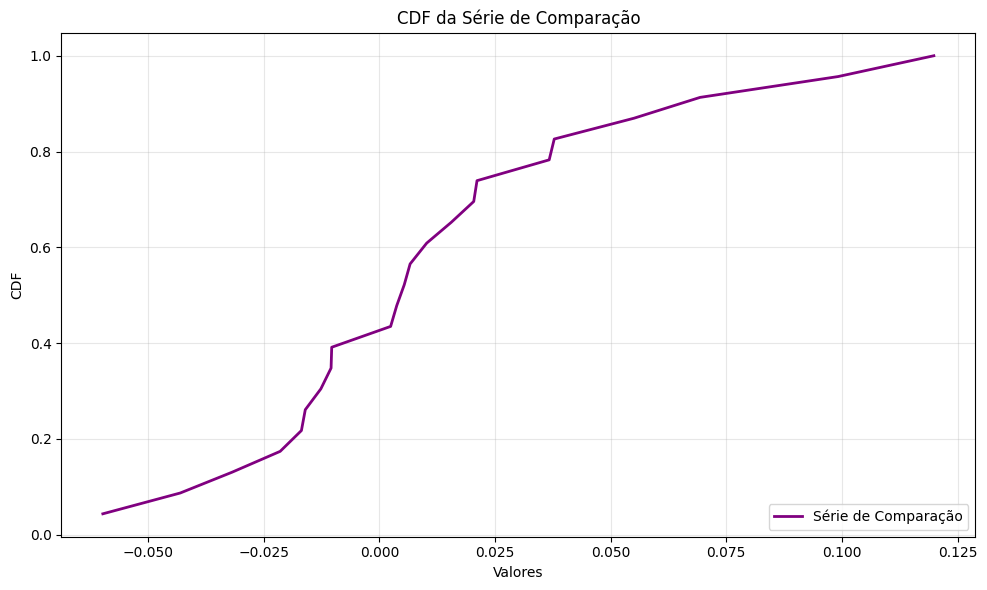

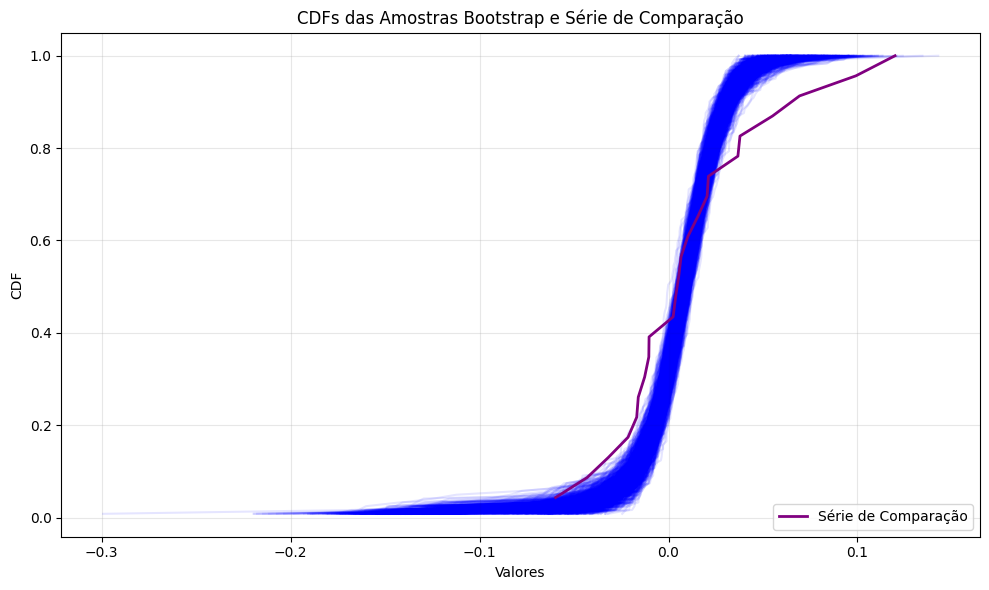

In [51]:
plot_separate_and_combined_cdfs(retorno_mensal_boot, retorno_mensal_sint)

# Fatos Estilizados

## Gaussianidade

In [52]:
print(f'Skewness dos retornos diários: ', skew(retorno_diario_sint, axis=0, bias=True))
print(f'Skewness dos retornos semanais: ', skew(retorno_semanal_sint, axis=0, bias=True))
print(f'Skewness dos retornos mensais: ', skew(retorno_mensal_sint, axis=0, bias=True))

Skewness dos retornos diários:  [0.15288927]
Skewness dos retornos semanais:  [1.4555819]
Skewness dos retornos mensais:  [0.852734]


In [53]:
print('Kurtosis dos retornos diários: ', kurtosis(retorno_diario_sint, axis=0, bias=True)+3)
print('Kurtosis dos retornos semanais: ', kurtosis(retorno_semanal_sint, axis=0, bias=True)+3)
print('Kurtosis dos retornos mensais: ', kurtosis(retorno_mensal_sint, axis=0, bias=True)+3)

Kurtosis dos retornos diários:  [18.1906448]
Kurtosis dos retornos semanais:  [8.70141948]
Kurtosis dos retornos mensais:  [3.50250905]


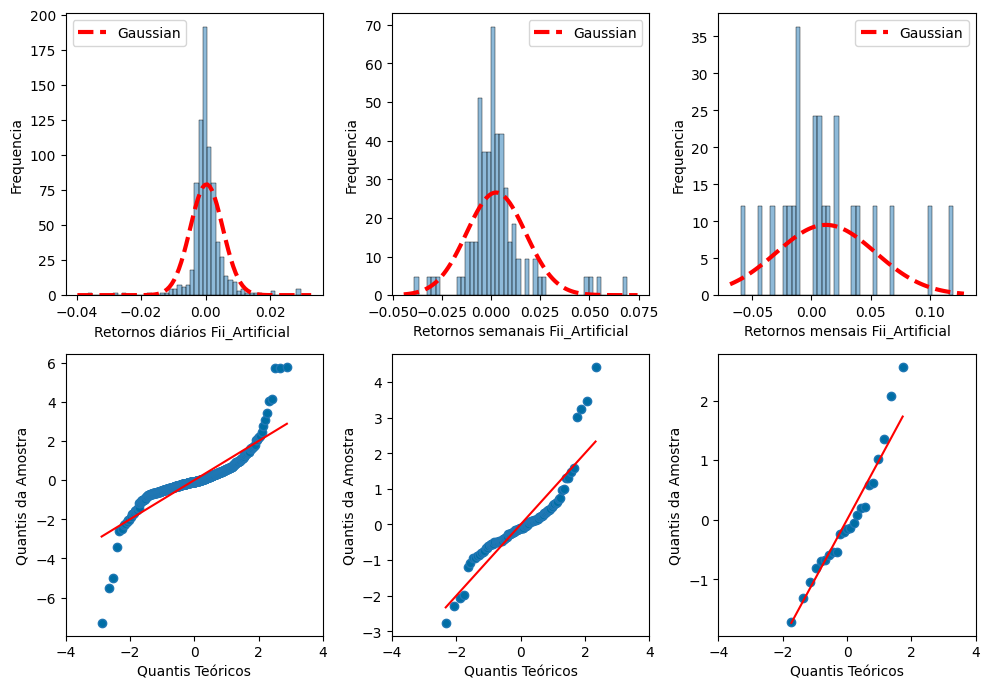

In [54]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(231)
sns.histplot(retorno_diario_sint, bins=50, color=color_ppgi_azul_claro, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(retorno_diario_sint), np.std(retorno_diario_sint))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel(f'Retornos diários Fii_Artificial ')
plt.ylabel('Frequencia')
plt.legend()

ax = fig.add_subplot(234)
qq = qqplot(np.sort(retorno_diario_sint, axis=0), line='s', ax=ax, markerfacecolor=color_ppgi_azul_claro, fit=True)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis da Amostra')
plt.xlim([-4,4]);

ax = fig.add_subplot(232)
sns.histplot(retorno_semanal_sint, bins=50, color=color_ppgi_azul_claro, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(retorno_semanal_sint), np.std(retorno_semanal_sint))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel(f'Retornos semanais Fii_Artificial')
plt.ylabel('Frequencia')
plt.legend()

ax = fig.add_subplot(235)
qq = qqplot(np.sort(retorno_semanal_sint, axis=0), line='s', ax=ax, markerfacecolor=color_ppgi_azul_claro, fit=True)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis da Amostra')
plt.xlim([-4,4]);

ax = fig.add_subplot(233)
sns.histplot(retorno_mensal_sint, bins=50, color=color_ppgi_azul_claro, stat='density', ax=ax)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(retorno_mensal_sint), np.std(retorno_mensal_sint))
plt.plot(x, p, color='r', linestyle='dashed', linewidth=3, label='Gaussian')
plt.xlabel(f'Retornos mensais Fii_Artificial')
plt.ylabel('Frequencia')
plt.legend()

ax = fig.add_subplot(236)
qq = qqplot(np.sort(retorno_mensal_sint, axis=0), line='s', ax=ax, markerfacecolor=color_ppgi_azul_claro, fit=True)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis da Amostra')
plt.xlim([-4,4]);

plt.tight_layout();

## Agrupamento de volatilidade

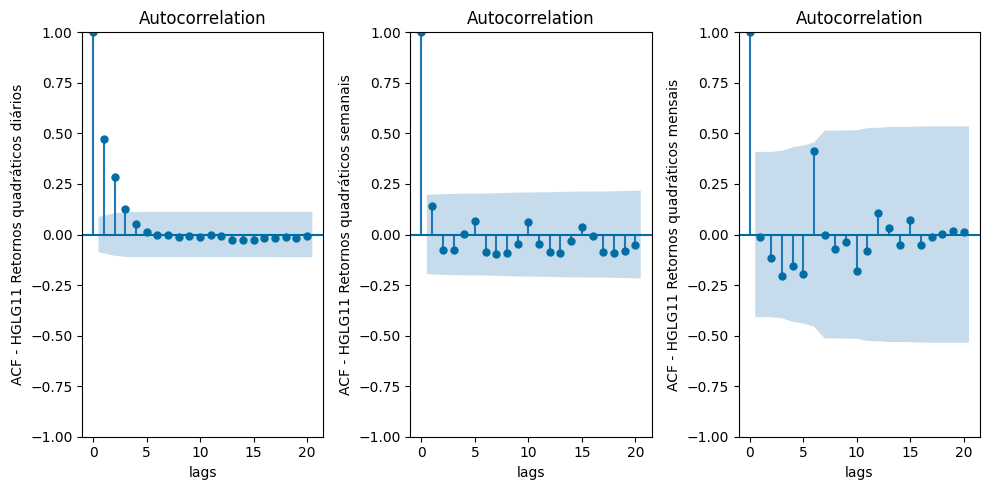

In [62]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(retorno_diario_sint**2, lags=20, ax=ax, alpha=0.05, color=color_ppgi_azul_claro)
plt.xlabel('lags')
plt.ylabel(f'ACF - {fii[:-3]} Retornos quadráticos diários')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(retorno_semanal_sint**2, lags=20, ax=ax, alpha=0.05, color=color_ppgi_azul_claro)
plt.xlabel('lags')
plt.ylabel(f'ACF - {fii[:-3]} Retornos quadráticos semanais')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(retorno_mensal_sint**2, lags=20, ax=ax, alpha=0.05, color=color_ppgi_azul_claro)
plt.xlabel('lags')
plt.ylabel(f'ACF - {fii[:-3]} Retornos quadráticos mensais')

plt.tight_layout()

## Decaimento lento da autocorrelação em retornos absolutos

In [68]:
def power(x, a, b):
    return a / np.power(x, b)

initial_guess = [1, 1]
lags = np.arange(1, 21)
daily_abs_acf = sm.tsa.stattools.acf(np.abs(retorno_diario_sint), nlags=lags[-1]-1)
weekly_abs_acf = sm.tsa.stattools.acf(np.abs(retorno_semanal_sint), nlags=lags[-1]-1)
monthly_abs_acf = sm.tsa.stattools.acf(np.abs(retorno_mensal_sint), nlags=lags[-1]-1)

popt_daily, pcov_daily = curve_fit(power, lags[1:], daily_abs_acf[1:], p0=initial_guess, maxfev=5000)
popt_weekly, pcov_weekly = curve_fit(power, lags[1:], weekly_abs_acf[1:], p0=initial_guess, maxfev=5000)
popt_monthly, pcov_monthly = curve_fit(power, lags[1:], monthly_abs_acf[1:], p0=initial_guess, maxfev=5000)

In [69]:
print('Lei de Potência para retornos diários - IYR: ', popt_daily)
print('Lei de Potência para retornos semanais - IYR: ', popt_weekly)
print('Lei de Potência para retornos mensais - IYR: ', popt_monthly)

Lei de Potência para retornos diários - IYR:  [2.25910599 1.88697144]
Lei de Potência para retornos semanais - IYR:  [1.66441764e+08 2.92159119e+01]
Lei de Potência para retornos mensais - IYR:  [-0.12838489  0.70224733]


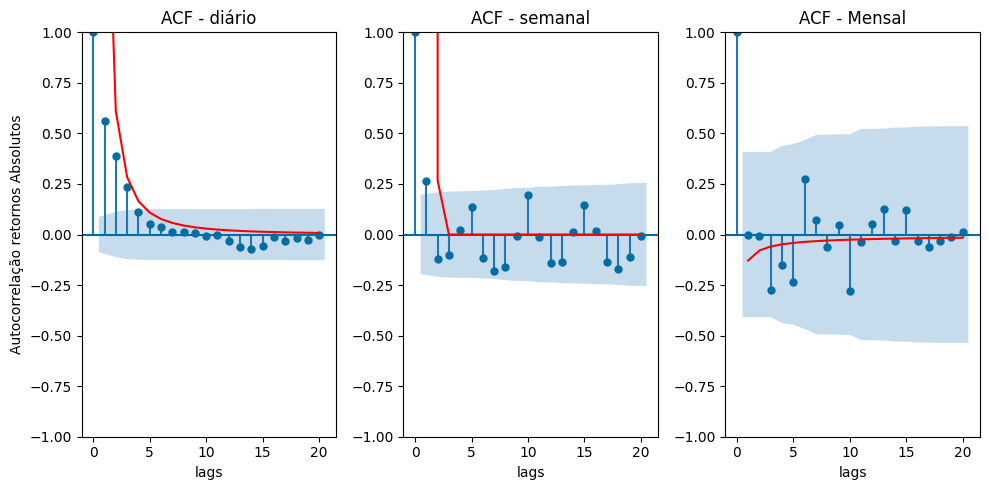

In [71]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(131)
sm.graphics.tsa.plot_acf(np.abs(retorno_diario_sint), lags=20, ax=ax, alpha=0.05, color=color_ppgi_azul_claro)
ax.plot(lags, power(lags, *popt_daily), 'r-')
plt.xlabel('lags')
plt.ylabel(f'Autocorrelação retornos Absolutos')
plt.title('ACF - diário')

ax = fig.add_subplot(132)
sm.graphics.tsa.plot_acf(np.abs(retorno_semanal_sint), lags=20, ax=ax, alpha=0.05, color=color_ppgi_azul_claro)
ax.plot(lags, power(lags, *popt_weekly), 'r-')
plt.xlabel('lags')
#plt.ylabel(f'ACF -  Retornos absolutos semanais')
plt.title('ACF - semanal')

ax = fig.add_subplot(133)
sm.graphics.tsa.plot_acf(np.abs(retorno_mensal_sint), lags=20, ax=ax, alpha=0.05, color=color_ppgi_azul_claro)
ax.plot(lags, power(lags, *popt_monthly), 'r-')
plt.xlabel('lags')
#plt.ylabel(f'ACF - Retornos absolutos mensais')
plt.title('ACF - Mensal')

plt.tight_layout()